# <font color="red">Boston Housing Prediction</font>

## Import the Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Utilities
import joblib
import math
import os
import json
from datetime import datetime
from itertools import cycle

## Scaler Selection

In [2]:
scaler_types = {
    'minmax': MinMaxScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

scaler_name = "standard"
scaler_selection = lambda: scaler_types[scaler_name]

## Trained Model and History Saving

These code are used to manage the best model and its performance for reuse or further research purpose

### Directory

In [3]:
# Model tracking configuration
MODEL_REGISTRY_FILE = "history_registry/model_registry_regression.csv"
MODELS_DIR = "saved_models_regression"

In [4]:
# Model tracking configuration for classification
MODEL_REGISTRY_FILE_CLASSIFICATION = "history_registry/model_registry_classification.csv"
MODELS_DIR_CLASSIFICATION = "saved_models_classification"

### Define the Registry or History File

In [5]:
def load_or_create_registry_regression():
    """Load existing model registry or create new one"""
    try:
        return pd.read_csv(MODEL_REGISTRY_FILE)
    except FileNotFoundError:
        return pd.DataFrame(columns=[
            'model_name', 'scaler_type', 'mse', 'mae', 'rmse', 'r2', 'timestamp', 
            'model_path', 'scaler_path', 'parameters'
        ])

In [6]:
def load_or_create_registry_classification():
    """Load existing model registry or create new one for classification"""
    try:
        return pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
    except FileNotFoundError:
        return pd.DataFrame(columns=[
            'model_name', 'scaler_type', 'accuracy', 'precision', 'recall', 'f1', 'timestamp',
            'model_path', 'scaler_path', 'parameters'
        ])

### Model Saving only for the Best Performance

In [7]:
def save_model_if_better_regression(model_name, model, scaler, mse, mae, rmse, r2, parameters=None):
    """Save model only if it performs better than existing version for the same scaler"""
    
    # Create directories
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(os.path.dirname(MODEL_REGISTRY_FILE), exist_ok=True)
    
    # Load registry
    registry = load_or_create_registry_regression()
    
    # Get current scaler type
    current_scaler_type = scaler_name
    
    # Check if model exists for the same scaler
    existing_model = registry[(registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type)]
    
    should_save = False
    old_model_path = None
    old_scaler_path = None
    
    if existing_model.empty:
        print(f"{model_name} ({current_scaler_type}): First time training - saving model")
        should_save = True
    else:
        existing_mse = existing_model['mse'].iloc[0]
        existing_r2 = existing_model['r2'].iloc[0]
        
        # Store old file paths for deletion
        old_model_path = existing_model['model_path'].iloc[0]
        old_scaler_path = existing_model['scaler_path'].iloc[0]
        
        # Check if current model is better (lower MSE and higher R2)
        if mse < existing_mse and r2 > existing_r2:
            print(f"{model_name} ({current_scaler_type}): Better performance - updating model")
            print(f"   MSE: {existing_mse:.4f} → {mse:.4f} (↓)")
            print(f"   R2:  {existing_r2:.4f} → {r2:.4f} (↑)")
            should_save = True
        else:
            print(f"{model_name} ({current_scaler_type}): No improvement - keeping existing model")
            print(f"   Current MSE: {mse:.4f} vs Best: {existing_mse:.4f}")
            print(f"   Current R2:  {r2:.4f} vs Best: {existing_r2:.4f}")
    
    if should_save:
        # Delete old model files if they exist
        if old_model_path and os.path.exists(old_model_path):
            try:
                os.remove(old_model_path)
                print(f"    Deleted old model: {old_model_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old model file: {e}")
                
        if old_scaler_path and os.path.exists(old_scaler_path):
            try:
                os.remove(old_scaler_path)
                print(f"    Deleted old scaler: {old_scaler_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old scaler file: {e}")
        
        # Save new model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name.lower().replace(' ', '_')}_{current_scaler_type}_{timestamp}.pkl"
        scaler_filename = f"{model_name.lower().replace(' ', '_')}_scaler_{current_scaler_type}_{timestamp}.pkl"
        
        model_path = os.path.join(MODELS_DIR, model_filename)
        scaler_path = os.path.join(MODELS_DIR, scaler_filename)
        
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        
        # Remove old entry from registry (if exists)
        registry = registry[~((registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type))]
        
        # Process parameters to make them JSON serializable
        json_serializable_params = None
        if parameters:
            try:
                # Create a copy of parameters and convert non-serializable objects to strings
                serializable_params = {}
                for key, value in parameters.items():
                    try:
                        # Try to serialize the value
                        json.dumps(value)
                        serializable_params[key] = value
                    except (TypeError, ValueError):
                        # If not serializable, convert to string representation
                        serializable_params[key] = str(value)
                
                json_serializable_params = json.dumps(serializable_params)
            except Exception as e:
                print(f"    Warning: Could not serialize parameters: {e}")
                json_serializable_params = json.dumps({"error": "Could not serialize parameters"})
        
        # Add new entry to registry
        new_entry = pd.DataFrame([{
            'model_name': model_name,
            'scaler_type': current_scaler_type,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'timestamp': timestamp,
            'model_path': model_path,
            'scaler_path': scaler_path,
            'parameters': json_serializable_params
        }])
        
        registry = pd.concat([registry, new_entry], ignore_index=True)
        registry.to_csv(MODEL_REGISTRY_FILE, index=False)
        
        print(f"    New model saved to: {model_path}")
        print(f"    New scaler saved to: {scaler_path}")
    
    return should_save

In [8]:
def save_model_if_better_classification(model_name, model, scaler, accuracy, precision, recall, f1, parameters=None):
    """Save classification model only if it performs better than existing version for the same scaler"""
    
    # Create directories
    os.makedirs(MODELS_DIR_CLASSIFICATION, exist_ok=True)
    os.makedirs(os.path.dirname(MODEL_REGISTRY_FILE_CLASSIFICATION), exist_ok=True)
    
    # Load registry
    registry = load_or_create_registry_classification()
    
    # Get current scaler type
    current_scaler_type = scaler_name
    
    # Check if model exists for the same scaler
    existing_model = registry[(registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type)]
    
    should_save = False
    old_model_path = None
    old_scaler_path = None
    
    if existing_model.empty:
        print(f"{model_name} ({current_scaler_type}): First time training - saving model")
        should_save = True
    else:
        existing_accuracy = existing_model['accuracy'].iloc[0]
        
        # Store old file paths for deletion
        old_model_path = existing_model['model_path'].iloc[0]
        old_scaler_path = existing_model['scaler_path'].iloc[0]
        
        # Check if current model is better (higher accuracy)
        if accuracy > existing_accuracy:
            print(f"{model_name} ({current_scaler_type}): Better performance - updating model")
            print(f"   Accuracy: {existing_accuracy:.4f} → {accuracy:.4f} (↑)")
            should_save = True
        else:
            print(f"{model_name} ({current_scaler_type}): No improvement - keeping existing model")
            print(f"   Current Accuracy: {accuracy:.4f} vs Best: {existing_accuracy:.4f}")
    
    if should_save:
        # Delete old model files if they exist
        if old_model_path and os.path.exists(old_model_path):
            try:
                os.remove(old_model_path)
                print(f"    Deleted old model: {old_model_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old model file: {e}")
                
        if old_scaler_path and os.path.exists(old_scaler_path):
            try:
                os.remove(old_scaler_path)
                print(f"    Deleted old scaler: {old_scaler_path}")
            except Exception as e:
                print(f"    Warning: Could not delete old scaler file: {e}")
        
        # Save new model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"{model_name.lower().replace(' ', '_')}_{current_scaler_type}_{timestamp}.pkl"
        scaler_filename = f"{model_name.lower().replace(' ', '_')}_scaler_{current_scaler_type}_{timestamp}.pkl"
        
        model_path = os.path.join(MODELS_DIR_CLASSIFICATION, model_filename)
        scaler_path = os.path.join(MODELS_DIR_CLASSIFICATION, scaler_filename)
        
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        
        # Remove old entry from registry (if exists)
        registry = registry[~((registry['model_name'] == model_name) & 
                             (registry['scaler_type'] == current_scaler_type))]
        
        # Process parameters to make them JSON serializable
        json_serializable_params = None
        if parameters:
            try:
                # Create a copy of parameters and convert non-serializable objects to strings
                serializable_params = {}
                for key, value in parameters.items():
                    try:
                        # Try to serialize the value
                        json.dumps(value)
                        serializable_params[key] = value
                    except (TypeError, ValueError):
                        # If not serializable, convert to string representation
                        serializable_params[key] = str(value)
                
                json_serializable_params = json.dumps(serializable_params)
            except Exception as e:
                print(f"    Warning: Could not serialize parameters: {e}")
                json_serializable_params = json.dumps({"error": "Could not serialize parameters"})
        
        # Add new entry to registry
        new_entry = pd.DataFrame([{
            'model_name': model_name,
            'scaler_type': current_scaler_type,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'timestamp': timestamp,
            'model_path': model_path,
            'scaler_path': scaler_path,
            'parameters': json_serializable_params
        }])
        
        registry = pd.concat([registry, new_entry], ignore_index=True)
        registry.to_csv(MODEL_REGISTRY_FILE_CLASSIFICATION, index=False)
        
        print(f"    New model saved to: {model_path}")
        print(f"    New scaler saved to: {scaler_path}")
    
    return should_save

### Show the history in descending order of R2 & F1

In [9]:
def show_model_registry_regression():
    """Display current model registry in descending order of R2"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        if not registry.empty:
            # Sort by R2 in descending order (best models first)
            registry_sorted = registry.sort_values('r2', ascending=False)
            
            print("\n" + "="*90)
            print("MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by R2)")
            print("="*90)
            display_cols = ['model_name', 'scaler_type', 'mse', 'mae', 'rmse', 'r2', 'timestamp']
            print(registry_sorted[display_cols].to_string(index=False))
        else:
            print("No models saved yet.")
    except FileNotFoundError:
        print("No model registry found.")

In [10]:
def show_model_registry_classification():
    """Display current classification model registry in descending order of F1"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
        if not registry.empty:
            # Sort by F1 in descending order (best models first)
            registry_sorted = registry.sort_values('f1', ascending=False)
            
            print("\n" + "="*90)
            print("CLASSIFICATION MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by F1)")
            print("="*90)
            display_cols = ['model_name', 'scaler_type', 'accuracy', 'precision', 'recall', 'f1', 'timestamp']
            print(registry_sorted[display_cols].to_string(index=False))
        else:
            print("No classification models saved yet.")
    except FileNotFoundError:
        print("No classification model registry found.")

### For Model Parameters

In [11]:
def view_model_parameters_regression(model_name=None, scaler_type=None):
    """View parameters of saved models"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        
        if model_name:
            if scaler_type:
                model_info = registry[(registry['model_name'] == model_name) & 
                                     (registry['scaler_type'] == scaler_type)]
                if model_info.empty:
                    print(f"No model found with name: {model_name} and scaler: {scaler_type}")
                    return
            else:
                model_info = registry[registry['model_name'] == model_name]
                if model_info.empty:
                    print(f"No model found with name: {model_name}")
                    return
            
            for _, row in model_info.iterrows():
                params_json = row['parameters']
                print(f"\n{row['model_name']} ({row['scaler_type']}) Parameters:")
                print("="*60)
                
                if params_json:
                    params = json.loads(params_json)
                    
                    if 'best_params' in params:
                        print("OPTIMIZED PARAMETERS:")
                        for key, value in params['best_params'].items():
                            print(f"   {key}: {value}")
                        print(f"\nCross-validation score: {params.get('cv_score', 'N/A')}")
                        
                        if 'all_params' in params:
                            print(f"\nCOMPLETE PARAMETER SET:")
                            all_params = params['all_params']
                            for key, value in sorted(all_params.items()):
                                print(f"   {key}: {value}")
                    else:
                        print("MODEL PARAMETERS:")
                        for key, value in sorted(params.items()):
                            print(f"   {key}: {value}")
                else:
                    print("No parameters saved for this model")
                print(f"Performance: MSE={row['mse']:.4f}, R2={row['r2']:.4f}")
        else:
            print("\n" + "="*90)
            print("ALL SAVED MODELS AND THEIR PARAMETERS")
            print("="*90)
            
            # Sort by R2 score descending (best first)
            registry_sorted = registry.sort_values('r2', ascending=False)
            
            for _, row in registry_sorted.iterrows():
                print(f"\n{row['model_name']} ({row['scaler_type']})")
                print(f"   Performance: MSE={row['mse']:.4f}, R2={row['r2']:.4f}")
                
                if row['parameters']:
                    params = json.loads(row['parameters'])
                    
                    if 'best_params' in params:
                        print("   Optimized Parameters:")
                        for key, value in params['best_params'].items():
                            print(f"      {key}: {value}")
                        print(f"   CV Score: {params.get('cv_score', 'N/A'):.4f}")
                    else:
                        print("   All Parameters:")
                        for key, value in sorted(params.items()):
                            if key not in ['algorithm']:
                                print(f"      {key}: {value}")
                else:
                    print("   No parameters saved")
                print(f"   Saved: {row['timestamp']}")
                
    except Exception as e:
        print(f"Error viewing parameters: {e}")

In [12]:
def view_model_parameters_classification(model_name=None, scaler_type=None):
    """View parameters of saved classification models"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
        
        if model_name:
            if scaler_type:
                model_info = registry[(registry['model_name'] == model_name) & 
                                     (registry['scaler_type'] == scaler_type)]
                if model_info.empty:
                    print(f"No model found with name: {model_name} and scaler: {scaler_type}")
                    return
            else:
                model_info = registry[registry['model_name'] == model_name]
                if model_info.empty:
                    print(f"No model found with name: {model_name}")
                    return
            
            for _, row in model_info.iterrows():
                params_json = row['parameters']
                print(f"\n{row['model_name']} ({row['scaler_type']}) Parameters:")
                print("="*60)
                
                if params_json:
                    params = json.loads(params_json)
                    
                    if 'best_params' in params:
                        print("OPTIMIZED PARAMETERS:")
                        for key, value in params['best_params'].items():
                            print(f"   {key}: {value}")
                        print(f"\nCross-validation score: {params.get('cv_score', 'N/A')}")
                        
                        if 'all_params' in params:
                            print(f"\nCOMPLETE PARAMETER SET:")
                            all_params = params['all_params']
                            for key, value in sorted(all_params.items()):
                                print(f"   {key}: {value}")
                    else:
                        print("MODEL PARAMETERS:")
                        for key, value in sorted(params.items()):
                            print(f"   {key}: {value}")
                else:
                    print("No parameters saved for this model")
                print(f"Performance: Accuracy={row['accuracy']:.4f}, F1={row['f1']:.4f}")
        else:
            print("\n" + "="*90)
            print("ALL SAVED CLASSIFICATION MODELS AND THEIR PARAMETERS")
            print("="*90)
            
            # Sort by F1 score descending (best first)
            registry_sorted = registry.sort_values('f1', ascending=False)
            
            for _, row in registry_sorted.iterrows():
                print(f"\n{row['model_name']} ({row['scaler_type']})")
                print(f"   Performance: Accuracy={row['accuracy']:.4f}, F1={row['f1']:.4f}")
                
                if row['parameters']:
                    params = json.loads(row['parameters'])
                    
                    if 'best_params' in params:
                        print("   Optimized Parameters:")
                        for key, value in params['best_params'].items():
                            print(f"      {key}: {value}")
                        print(f"   CV Score: {params.get('cv_score', 'N/A'):.4f}")
                    else:
                        print("   All Parameters:")
                        for key, value in sorted(params.items()):
                            if key not in ['algorithm']:
                                print(f"      {key}: {value}")
                else:
                    print("   No parameters saved")
                print(f"   Saved: {row['timestamp']}")
                
    except Exception as e:
        print(f"Error viewing parameters: {e}")

# Usage examples:
# view_model_parameters_classification()  # View all classification models with their parameters
# view_model_parameters_classification("Random Forest Classifier")  # View specific model parameters  
# view_model_parameters_classification("Random Forest Classifier", "minmax")  # View specific model with specific scaler

### For Testing the Best Model and Reuse

In [13]:
# Function to load the best model
def load_best_model_regression(model_name, scaler_type=None):
    """Load the best saved model and scaler"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE)
        
        if scaler_type:
            model_info = registry[(registry['model_name'] == model_name) & 
                                 (registry['scaler_type'] == scaler_type)]
            if model_info.empty:
                print(f"No saved model found for: {model_name} with {scaler_type} scaler")
                return None, None
        else:
            model_info = registry[registry['model_name'] == model_name]
            if model_info.empty:
                print(f"No saved model found for: {model_name}")
                return None, None
            # Get the best performing model (highest R2)
            model_info = model_info.loc[model_info['r2'].idxmax():model_info['r2'].idxmax()]
            
        model_path = model_info['model_path'].iloc[0]
        scaler_path = model_info['scaler_path'].iloc[0]
        used_scaler = model_info['scaler_type'].iloc[0]
        
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        print(f"Loaded {model_name} ({used_scaler}) from {model_path}")
        return model, scaler
        
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

# Example usage:
print("\n" + "="*50)
print("USAGE EXAMPLES")
print("="*50)
print("# To load a specific model:")
print("model, scaler = load_best_model_regression('Random Forest Tuned')")
print("\n# To make predictions:")
print("# scaled_data = scaler.transform(new_data)")
print("# predictions = model.predict(scaled_data)")


USAGE EXAMPLES
# To load a specific model:
model, scaler = load_best_model_regression('Random Forest Tuned')

# To make predictions:
# scaled_data = scaler.transform(new_data)
# predictions = model.predict(scaled_data)


In [14]:
def load_best_model_classification(model_name, scaler_type=None):
    """Load the best saved classification model and scaler"""
    try:
        registry = pd.read_csv(MODEL_REGISTRY_FILE_CLASSIFICATION)
        
        if scaler_type:
            model_info = registry[(registry['model_name'] == model_name) & 
                                 (registry['scaler_type'] == scaler_type)]
            if model_info.empty:
                print(f"No saved classification model found for: {model_name} with {scaler_type} scaler")
                return None, None
        else:
            model_info = registry[registry['model_name'] == model_name]
            if model_info.empty:
                print(f"No saved classification model found for: {model_name}")
                return None, None
            # Get the best performing model (highest F1)
            model_info = model_info.loc[model_info['f1'].idxmax():model_info['f1'].idxmax()]
            
        model_path = model_info['model_path'].iloc[0]
        scaler_path = model_info['scaler_path'].iloc[0]
        used_scaler = model_info['scaler_type'].iloc[0]
        
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        print(f"Loaded {model_name} ({used_scaler}) from {model_path}")
        return model, scaler
        
    except Exception as e:
        print(f"Error loading classification model: {e}")
        return None, None

# Example usage:
print("\n" + "="*50)
print("USAGE EXAMPLES")
print("="*50)
print("# To load a specific model:")
print("model, scaler = load_best_model_classification('Random Forest')")
print("\n# To make predictions:")
print("# scaled_data = scaler.transform(new_data)")
print("# predictions = model.predict(scaled_data)")


USAGE EXAMPLES
# To load a specific model:
model, scaler = load_best_model_classification('Random Forest')

# To make predictions:
# scaled_data = scaler.transform(new_data)
# predictions = model.predict(scaled_data)


## Import the Datasets

In [15]:
# Load the dataset
boston = pd.read_csv('Datasets/BostonHousingData.csv')
boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2

In [16]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [17]:
boston.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  486.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.999513    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.175000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     76.800000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     93.975000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  486.000000  506.000000  
mean    12.715432   22.532806  
std      7.155871    9.197104  
min      1.730000    5.000000  
25%      7.125000   17.025000  
50%     11.430000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

### Datasets Description

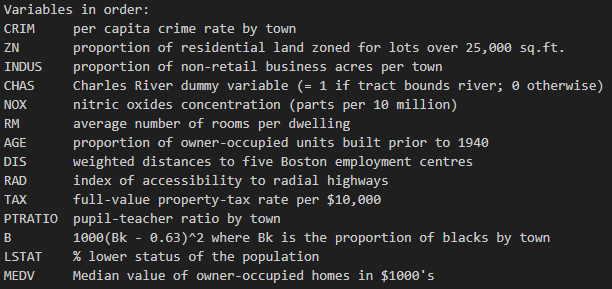

### Handle Null Value

In [18]:
boston.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [19]:
# Fill missing values as specified
boston['CRIM'] = boston['CRIM'].fillna(boston['CRIM'].mean())
boston['ZN'] = boston['ZN'].fillna(boston['ZN'].mean())
boston['INDUS'] = boston['INDUS'].fillna(boston['INDUS'].mean())
boston['CHAS'] = boston['CHAS'].fillna(boston['CHAS'].mode()[0])
boston['AGE'] = boston['AGE'].fillna(boston['AGE'].mean())
boston['LSTAT'] = boston['LSTAT'].fillna(boston['LSTAT'].mean())

In [20]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Check for Duplicate

In [21]:
duplicates =  boston[boston.duplicated(keep='first')]
duplicates

Empty DataFrame
Columns: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT, MEDV]
Index: []

No Duplicate Data

### Add MEDV_Class for Classification Problem

In [22]:
# Calculate percentiles for MEDV
low_threshold = boston['MEDV'].quantile(0.25)
high_threshold = boston['MEDV'].quantile(0.75)

def classify_medv(value):
    if value <= low_threshold:
        return 'Low'
    elif value <= high_threshold:
        return 'Medium'
    else:
        return 'High'

boston['MEDV_Class'] = boston['MEDV'].apply(classify_medv)

boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B      LSTAT  MEDV MEDV_Class  
0  396.90   4.980000  24.0     Medium  
1  396.90   9.140000  21.6     Medium  
2  392.83   4.030000  34.7       High  
3  394.63   2.940000  33.4       High  
4  396.90  12.715432  36.2       High

## Data Visualization

### Visualize with Graph

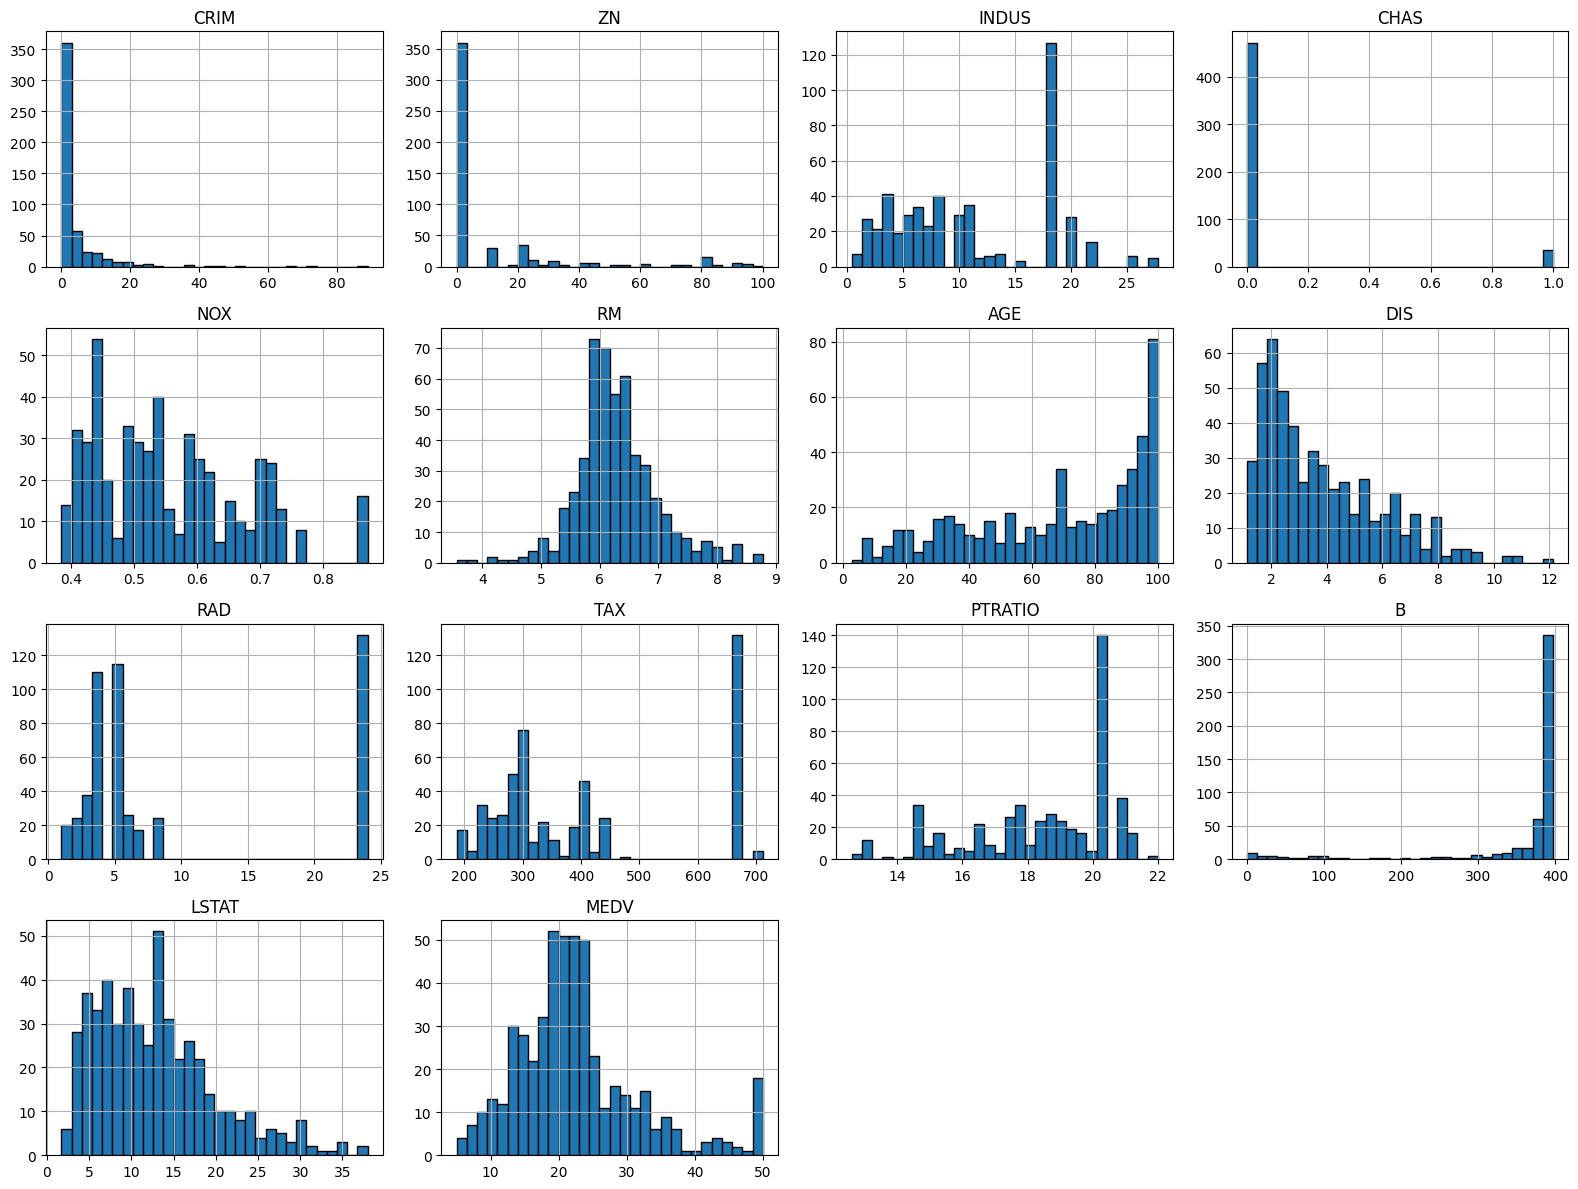

In [23]:
boston.hist(figsize=(16, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

array([[<Axes: xlabel='CRIM', ylabel='CRIM'>,
        <Axes: xlabel='ZN', ylabel='CRIM'>,
        <Axes: xlabel='INDUS', ylabel='CRIM'>,
        <Axes: xlabel='CHAS', ylabel='CRIM'>,
        <Axes: xlabel='NOX', ylabel='CRIM'>,
        <Axes: xlabel='RM', ylabel='CRIM'>,
        <Axes: xlabel='AGE', ylabel='CRIM'>,
        <Axes: xlabel='DIS', ylabel='CRIM'>,
        <Axes: xlabel='RAD', ylabel='CRIM'>,
        <Axes: xlabel='TAX', ylabel='CRIM'>,
        <Axes: xlabel='PTRATIO', ylabel='CRIM'>,
        <Axes: xlabel='B', ylabel='CRIM'>,
        <Axes: xlabel='LSTAT', ylabel='CRIM'>,
        <Axes: xlabel='MEDV', ylabel='CRIM'>],
       [<Axes: xlabel='CRIM', ylabel='ZN'>,
        <Axes: xlabel='ZN', ylabel='ZN'>,
        <Axes: xlabel='INDUS', ylabel='ZN'>,
        <Axes: xlabel='CHAS', ylabel='ZN'>,
        <Axes: xlabel='NOX', ylabel='ZN'>,
        <Axes: xlabel='RM', ylabel='ZN'>,
        <Axes: xlabel='AGE', ylabel='ZN'>,
        <Axes: xlabel='DIS', ylabel='ZN'>,
        <Axes: x

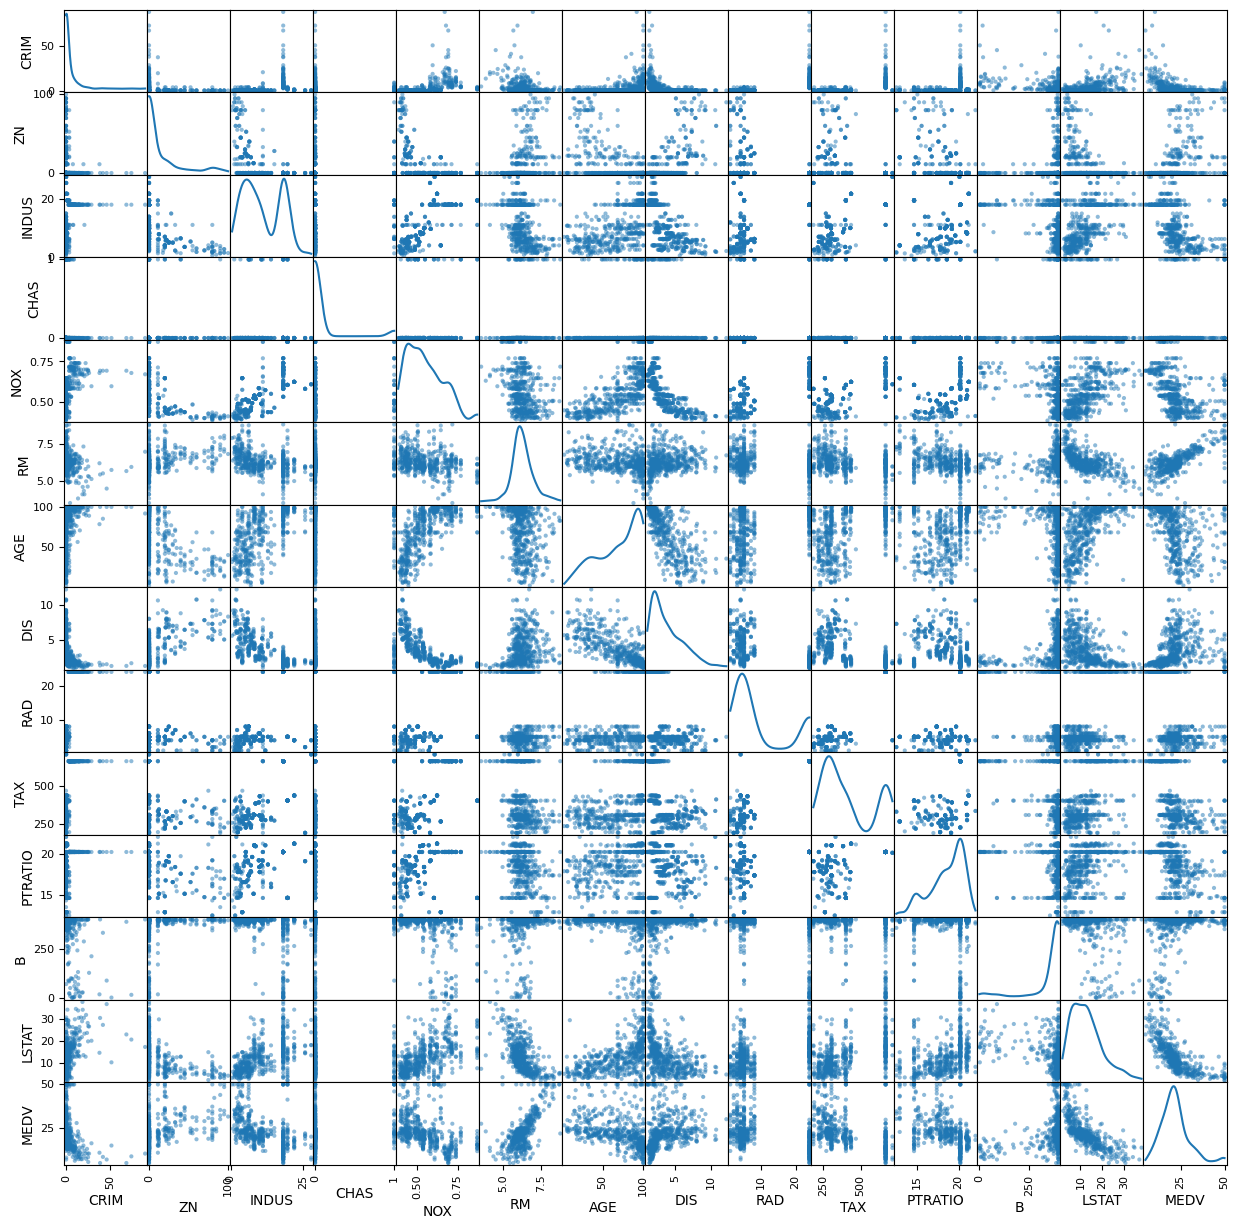

In [24]:
pd.plotting.scatter_matrix(boston, figsize=(15, 15), diagonal='kde')

### Heatmap of the Correlation

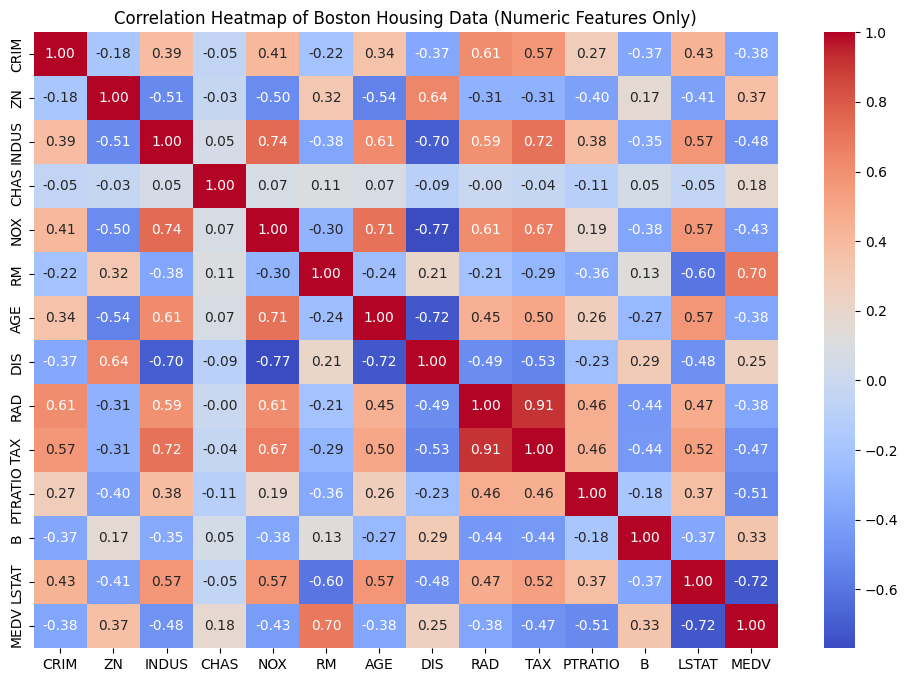

In [25]:
plt.figure(figsize=(12, 8))
corr = boston.select_dtypes(include=[float, int]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Boston Housing Data (Numeric Features Only)')
plt.show()

In [26]:
numeric_cols = boston.select_dtypes(include=[float, int]).columns
correlations = boston[numeric_cols].corr()['MEDV'].sort_values(ascending=False)
print(correlations)

MEDV       1.000000
RM         0.695360
ZN         0.365943
B          0.333461
DIS        0.249929
CHAS       0.183844
CRIM      -0.379695
AGE       -0.380223
RAD       -0.381626
NOX       -0.427321
TAX       -0.468536
INDUS     -0.478657
PTRATIO   -0.507787
LSTAT     -0.721975
Name: MEDV, dtype: float64


### Scatter Plot for the most impact Features

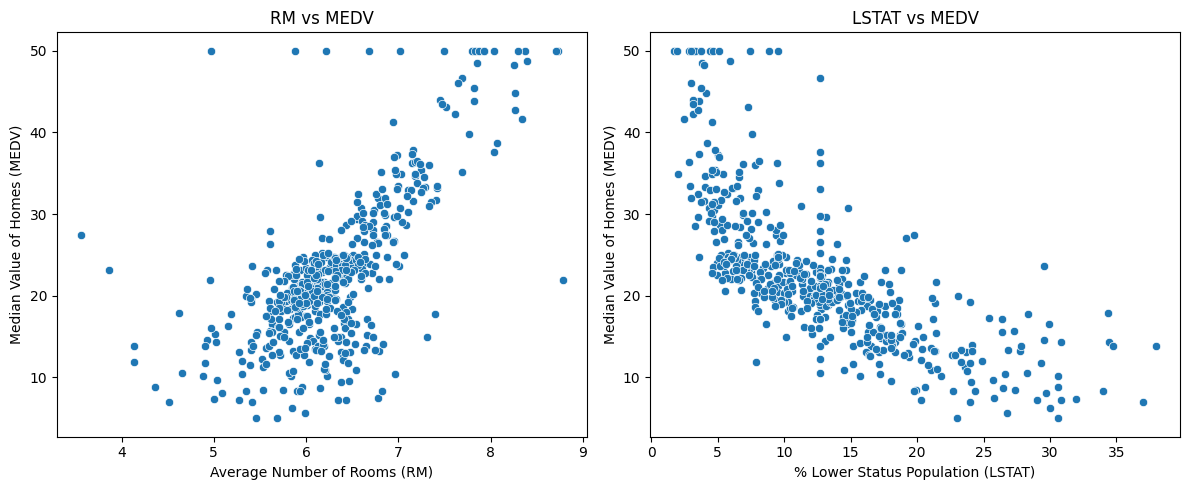

In [27]:
plt.figure(figsize=(12, 5))

# RM vs MEDV
plt.subplot(1, 2, 1)
sns.scatterplot(x='RM', y='MEDV', data=boston)
plt.title('RM vs MEDV')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')

# LSTAT vs MEDV
plt.subplot(1, 2, 2)
sns.scatterplot(x='LSTAT', y='MEDV', data=boston)
plt.title('LSTAT vs MEDV')
plt.xlabel('% Lower Status Population (LSTAT)')
plt.ylabel('Median Value of Homes (MEDV)')

plt.tight_layout()
plt.show()

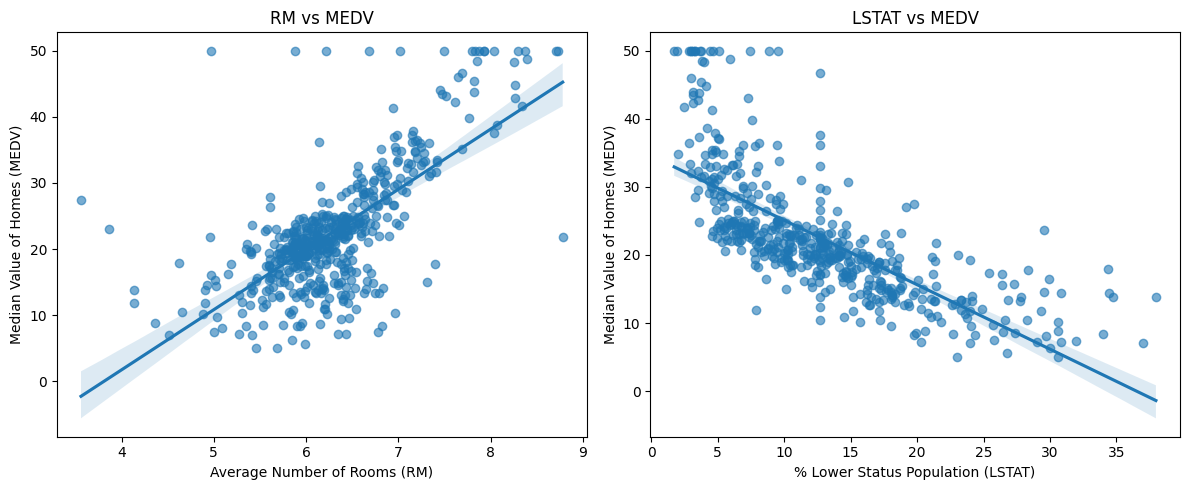

In [28]:
plt.figure(figsize=(12, 5))

# RM vs MEDV with regression line
plt.subplot(1, 2, 1)
sns.regplot(x='RM', y='MEDV', data=boston, scatter_kws={'alpha':0.6})
plt.title('RM vs MEDV')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')

# LSTAT vs MEDV with regression line
plt.subplot(1, 2, 2)
sns.regplot(x='LSTAT', y='MEDV', data=boston, scatter_kws={'alpha':0.6})
plt.title('LSTAT vs MEDV')
plt.xlabel('% Lower Status Population (LSTAT)')
plt.ylabel('Median Value of Homes (MEDV)')

plt.tight_layout()
plt.show()

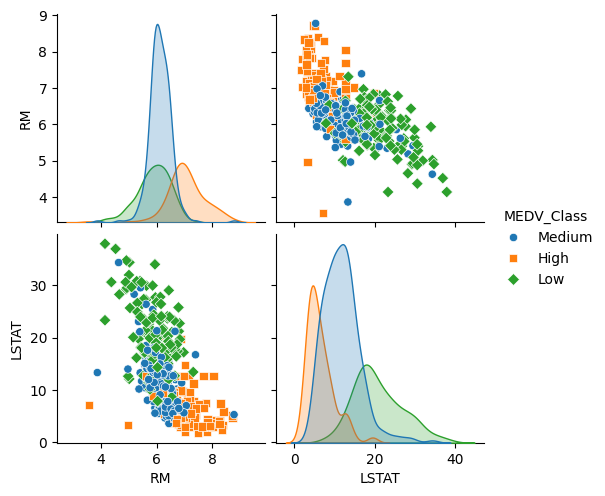

In [29]:
sns.pairplot(
    boston,
    vars=["RM", "LSTAT"],
    hue="MEDV_Class",
    markers=["o", "s", "D"]
)

## Training Regression Model

### Data Split

In [30]:
# Stratified split based on MEDV_Class
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(boston, boston['MEDV_Class']):
    boston_train = boston.iloc[train_idx]
    boston_test = boston.iloc[test_idx]

In [31]:
# Show the count of each unique class in MEDV_Class
class_counts = boston['MEDV_Class'].value_counts().reset_index()
class_counts.columns = ['MEDV_Class', 'Count']

print("Distribution of data based on MEDV_Class:")
print(class_counts)

Distribution of data based on MEDV_Class:
  MEDV_Class  Count
0     Medium    255
1        Low    127
2       High    124


In [32]:
print("Distribution of MEDV_Class in Training Set:")
print(boston_train['MEDV_Class'].value_counts())

print("\nDistribution of MEDV_Class in Test Set:")
print(boston_test['MEDV_Class'].value_counts())

Distribution of MEDV_Class in Training Set:
MEDV_Class
Medium    204
Low       101
High       99
Name: count, dtype: int64

Distribution of MEDV_Class in Test Set:
MEDV_Class
Medium    51
Low       26
High      25
Name: count, dtype: int64


In [33]:
X_train = boston_train.drop(columns=['MEDV', 'MEDV_Class'])
y_train = boston_train['MEDV']

In [34]:
X_test = boston_test.drop(columns=['MEDV', 'MEDV_Class'])
y_test = boston_test['MEDV']

In [35]:
print("X_train: ", len(X_train))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test))
print("y_test: ", len(y_test))

X_train:  404
y_train:  404

X_test:  102
y_test:  102


### Data Scaling

In [36]:
scaler = scaler_selection()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
X_train

array([[-0.46812931, -0.48154213,  0.42260081, ..., -0.96253272,
         0.40303953,  0.1064974 ],
       [ 0.72525103, -0.48154213,  1.04744763, ...,  0.79097414,
         0.23652719,  0.68969288],
       [ 0.41439445, -0.48154213,  1.04744763, ...,  0.79097414,
         0.4483415 ,  0.17494088],
       ...,
       [-0.45301938, -0.48154213, -0.03453178, ...,  0.32952497,
         0.22779827, -0.41110642],
       [ 0.28578509, -0.48154213,  1.04744763, ...,  0.79097414,
         0.40171362,  0.31610555],
       [-0.46206318, -0.48154213, -1.27383604, ..., -0.31650388,
         0.41762456, -1.13261477]], shape=(404, 13))

In [38]:
X_test

array([[ 0.84991065, -0.48154213,  1.04744763, ...,  0.79097414,
        -0.20069203,  2.45353839],
       [-0.46610504, -0.48154213,  0.13169825, ...,  1.16013348,
         0.4483415 , -1.01569049],
       [-0.3465969 , -0.48154213, -0.4308123 , ...,  1.16013348,
        -0.55183751,  0.64406389],
       ...,
       [-0.30707018, -0.48154213, -0.4308123 , ...,  1.16013348,
         0.22371004,  1.17735267],
       [-0.46243305, -0.48154213, -0.03453178, ...,  0.32952497,
         0.30282275, -0.86169266],
       [-0.42491992, -0.48154213, -0.16959368, ..., -0.03963437,
         0.43497189, -0.49666077]], shape=(102, 13))

### Training The Model

#### Linear Regression

In [39]:
LR = LinearRegression()
LR

LinearRegression()

In [40]:
%%time
LR.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 2.41 ms


LinearRegression()

In [41]:
y_pred = LR.predict(X_test)
y_pred

array([11.79313985, 27.26714293, 14.81463407, 21.45696073, 15.24564389,
       20.5140206 , 27.77453834, 29.67506015, 36.13615564, 22.84406559,
       32.58635833, 14.09855017, 19.64482157, 29.23500732, 25.13566744,
       18.75554935, 25.63014908,  8.7752387 , 19.52122296, 23.92570598,
       14.9507333 ,  2.1385725 ,  6.902059  , 21.29432838, 29.88246075,
       11.83943753, 31.06260984, 25.52633063, 26.49644226, 22.12053797,
       25.97971787, 19.56387495, 17.66504541, 31.20265623, 28.55905891,
       27.30250226, 18.04048703, 37.86920121, 14.43117821, 31.06603537,
       36.22357813, 20.71908817, 31.0221969 , 24.24121587, 39.69067619,
       22.28067503, 20.34903899, 29.1614852 , 28.65516472, 20.49982567,
       13.45432102, 19.18786604, 22.45758667, 25.36926693, 34.17616286,
       24.91952816, 34.51452971, 20.26082669, 18.57345745, 19.23160543,
       28.77872558, 13.92097015, 13.49734959, 23.32820338, 17.18938356,
       27.98449054, 24.95990996, 17.13258627, 22.81595001, 12.56

In [42]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [43]:
MSE_LR = mean_squared_error(y_test, y_pred)
MAE_LR = mean_absolute_error(y_test, y_pred)
R2_LR = r2_score(y_test, y_pred)
RMSE_LR = math.sqrt(MSE_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression",
    model=LR,
    scaler=scaler,
    mse=MSE_LR,
    mae=MAE_LR,
    rmse=RMSE_LR,
    r2=R2_LR,
    parameters=LR.get_params()
)

Linear Regression (standard): No improvement - keeping existing model
   Current MSE: 20.7810 vs Best: 20.7810
   Current R2:  0.7248 vs Best: 0.7248


False

In [44]:
print("MSE_LR:", MSE_LR)
print("MAE_LR:", MAE_LR)
print("R2_LR:", R2_LR)
print("RMSE_LR:", RMSE_LR)

MSE_LR: 20.78103496813959
MAE_LR: 3.446395971388114
R2_LR: 0.7247912810542856
RMSE_LR: 4.558622047081727


#### Decision Tree Regressor

In [45]:
DTR = DecisionTreeRegressor()
DTR

DecisionTreeRegressor()

In [46]:
%%time
DTR.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 9.15 ms


DecisionTreeRegressor()

In [47]:
y_pred = DTR.predict(X_test)
y_pred

array([ 9.5, 23.6, 13.9, 16.1, 19.6, 17.6, 24.5, 23.7, 36. , 20.1, 37. ,
       12.7, 20.6, 23.9, 27.5, 15.1, 23. , 13.4, 20.6, 19.1, 12.7, 12. ,
        7. , 20.4, 20.2,  9.6, 24.7, 25. , 23.8, 18.6, 22. , 14.6, 15.1,
       23.7, 29. , 22.1, 12.1, 45.4, 17.8, 30.1, 50. , 16.1, 29. , 23.9,
       37.6, 20.7, 24.5, 20.8, 34.9, 17.2, 11.3, 19.4, 18.6, 20.4, 34.9,
       24.4, 22. , 15.2, 17.2, 12.6, 23.1, 12.7, 13.3, 19.1, 12.7, 22.6,
       24. , 17.7, 22.4, 17.8, 18.6, 14.3, 36.1, 43.1, 16.8, 43.5, 22. ,
       22.4, 19.4, 33. , 18.5, 17.7, 29.9, 32.7, 24.5, 18.9, 50. , 28. ,
       23.7, 25. , 16.5,  7. , 22. , 50. , 50. , 19. , 23.3, 15.6, 33.1,
       12.7, 22.6, 23.9])

In [48]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [49]:
MSE_DTR = mean_squared_error(y_test, y_pred)
MAE_DTR = mean_absolute_error(y_test, y_pred)
R2_DTR = r2_score(y_test, y_pred)
RMSE_DTR = math.sqrt(MSE_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree",
    model=DTR,
    scaler=scaler,
    mse=MSE_DTR,
    mae=MAE_DTR,
    rmse=RMSE_DTR,
    r2=R2_DTR,
    parameters=DTR.get_params()
)

Decision Tree (standard): No improvement - keeping existing model
   Current MSE: 32.7665 vs Best: 16.7051
   Current R2:  0.5661 vs Best: 0.7788


False

In [50]:
print("MSE_DTR:", MSE_DTR)
print("MAE_DTR:", MAE_DTR)
print("R2_DTR:", R2_DTR)
print("RMSE_DTR:", RMSE_DTR)

MSE_DTR: 32.76647058823529
MAE_DTR: 3.266666666666667
R2_DTR: 0.5660650006707553
RMSE_DTR: 5.724200432220669


#### Random Forest Regressor

In [51]:
RFR = RandomForestRegressor(random_state=42)
RFR

RandomForestRegressor(random_state=42)

In [52]:
%%time
RFR.fit(X_train, y_train)

CPU times: total: 531 ms
Wall time: 579 ms


RandomForestRegressor(random_state=42)

In [53]:
y_pred = RFR.predict(X_test)
y_pred

array([ 9.684, 26.653, 15.408, 20.455, 20.291, 19.918, 25.826, 24.944,
       33.796, 20.916, 30.994, 15.619, 20.179, 23.436, 27.035, 15.017,
       24.242, 14.355, 20.367, 20.904, 17.498, 13.845,  7.757, 19.476,
       22.417, 10.396, 24.626, 23.436, 24.609, 18.517, 24.937, 13.873,
       14.439, 25.203, 30.718, 21.402, 13.952, 41.534, 11.714, 25.959,
       43.242, 15.905, 29.665, 25.876, 43.205, 23.707, 20.334, 20.998,
       35.358, 12.821, 10.681, 20.634, 18.892, 20.564, 32.982, 22.881,
       27.185, 17.878, 11.087, 14.363, 24.962, 14.567, 14.975, 20.616,
       14.673, 22.445, 21.466, 17.932, 21.094, 18.462, 20.793, 15.815,
       33.642, 44.261, 21.36 , 45.328, 22.577, 20.853, 18.389, 30.918,
       19.854, 17.171, 32.601, 30.477, 20.407, 17.59 , 33.998, 25.163,
       26.666, 22.705, 21.166,  8.093, 22.08 , 48.813, 20.657, 16.938,
       24.332, 16.3  , 30.779, 15.186, 23.88 , 24.141])

In [54]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [55]:
MSE_RFR = mean_squared_error(y_test, y_pred)
MAE_RFR = mean_absolute_error(y_test, y_pred)
R2_RFR = r2_score(y_test, y_pred)
RMSE_RFR = math.sqrt(MSE_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest",
    model=RFR,
    scaler=scaler,
    mse=MSE_RFR,
    mae=MAE_RFR,
    rmse=RMSE_RFR,
    r2=R2_RFR,
    parameters=RFR.get_params()
)

Random Forest (standard): No improvement - keeping existing model
   Current MSE: 8.8918 vs Best: 8.8918
   Current R2:  0.8822 vs Best: 0.8822


False

In [56]:
print("MSE_RFR:", MSE_RFR)
print("MAE_RFR:", MAE_RFR)
print("R2_RFR:", R2_RFR)
print("RMSE_RFR:", RMSE_RFR)

MSE_RFR: 8.89175460784314
MAE_RFR: 2.1613333333333333
R2_RFR: 0.8822441520089873
RMSE_RFR: 2.9819045269497044


#### Support Vector Machine

In [57]:
SVR_model = SVR()
SVR_model

SVR()

In [58]:
%%time
SVR_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 12.3 ms


SVR()

In [59]:
y_pred = SVR_model.predict(X_test)
y_pred

array([11.4654691 , 24.63001667, 16.57690867, 19.518263  , 18.22978079,
       18.69026163, 26.03331097, 26.58741627, 32.00933549, 19.55765272,
       27.67183891, 15.7264189 , 19.59737528, 26.02170119, 21.07280112,
       15.7882922 , 25.84474236, 16.474746  , 19.45514271, 21.24184145,
       15.74446768, 15.10407631, 11.87119747, 18.61220213, 24.81703098,
       12.01072847, 28.2228759 , 23.29009466, 24.85676419, 22.62471018,
       24.42867958, 15.21321613, 14.75045521, 27.07327425, 28.62483166,
       23.19379734, 14.32795138, 32.46084129, 12.59942337, 27.13207539,
       29.40530814, 16.57655906, 29.12992263, 25.45917788, 34.46366918,
       20.29572638, 21.02275544, 24.32351293, 28.29502343, 14.76968538,
       12.27937106, 18.70154618, 22.20484115, 21.90154157, 29.43301004,
       24.13351107, 31.27352052, 17.83383547, 13.33344215, 15.00803689,
       26.5346532 , 16.22324279, 15.53349058, 20.52590424, 14.66673239,
       25.57715348, 21.72288143, 17.56587095, 20.9201221 , 21.26

In [60]:
y_test

399     6.3
503    23.9
27     14.8
119    19.3
492    20.1
       ... 
156    13.1
4      36.2
20     13.6
70     24.2
314    23.8
Name: MEDV, Length: 102, dtype: float64

In [61]:
MSE_SVR = mean_squared_error(y_test, y_pred)
MAE_SVR = mean_absolute_error(y_test, y_pred)
R2_SVR = r2_score(y_test, y_pred)
RMSE_SVR = math.sqrt(MSE_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR",
    model=SVR_model,
    scaler=scaler,
    mse=MSE_SVR,
    mae=MAE_SVR,
    rmse=RMSE_SVR,
    r2=R2_SVR,
    parameters=SVR_model.get_params()
)

SVR (standard): No improvement - keeping existing model
   Current MSE: 22.4143 vs Best: 22.4143
   Current R2:  0.7032 vs Best: 0.7032


False

In [62]:
print("MSE_SVR:", MSE_SVR)
print("MAE_SVR:", MAE_SVR)
print("R2_SVR:", R2_SVR)
print("RMSE_SVR:", RMSE_SVR)

MSE_SVR: 22.414281718986157
MAE_SVR: 2.949381822257666
R2_SVR: 0.7031617642033752
RMSE_SVR: 4.734372368011008


### Grid Search CV - Hyperparameters Tuning

#### Tuning Linear Regressor

In [63]:
linear_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [64]:
linear_grid_search = GridSearchCV(
    LinearRegression(), 
    linear_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)

In [65]:
%%time
print("Starting hyperparameter tuning for Linear Regression...")
linear_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Linear Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 93.8 ms
Wall time: 5.71 s


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

In [66]:
print("LINEAR REGRESSION TUNING RESULTS")
print("="*50)
print("Best Parameters:", linear_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", linear_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -linear_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-linear_grid_search.best_score_))

LINEAR REGRESSION TUNING RESULTS
Best Parameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Best Cross-Validation Score (Negative MSE): -26.174795333860896
Best Cross-Validation Score (MSE): 26.174795333860896
Best Cross-Validation Score (RMSE): 5.116130894910811


In [67]:
GSCV_LR_Model = linear_grid_search.best_estimator_
y_pred = GSCV_LR_Model.predict(X_test)

In [68]:
MSE_GSCV_LR = mean_squared_error(y_test, y_pred)
MAE_GSCV_LR = mean_absolute_error(y_test, y_pred)
R2_GSCV_LR = r2_score(y_test, y_pred)
RMSE_GSCV_LR = math.sqrt(MSE_GSCV_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression Tuned (GSCV)",
    model=GSCV_LR_Model,
    scaler=scaler,
    mse=MSE_GSCV_LR,
    mae=MAE_GSCV_LR,
    rmse=RMSE_GSCV_LR,
    r2=R2_GSCV_LR,
    parameters={
        "best_params": linear_grid_search.best_params_,
        "cv_score": linear_grid_search.best_score_,
        "all_params": GSCV_LR_Model.get_params()
    }
)

Linear Regression Tuned (GSCV) (standard): No improvement - keeping existing model
   Current MSE: 20.7810 vs Best: 20.7810
   Current R2:  0.7248 vs Best: 0.7248


False

In [69]:
print("MSE_GSCV_LR:", MSE_GSCV_LR)
print("MAE_GSCV_LR:", MAE_GSCV_LR)
print("R2_GSCV_LR:", R2_GSCV_LR)
print("RMSE_GSCV_LR:", RMSE_GSCV_LR)

MSE_GSCV_LR: 20.78103496813959
MAE_GSCV_LR: 3.446395971388114
R2_GSCV_LR: 0.7247912810542856
RMSE_GSCV_LR: 4.558622047081727


#### Tuning Decision Tree Regressor

In [70]:
decision_tree_param_grid = {
    'max_depth': [None, 5, 10, 15, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None, 0.5],
    'criterion': ['squared_error', 'friedman_mse'],
    'min_impurity_decrease': [0.0, 0.01, 0.02],
    'ccp_alpha': [0.0, 0.01, 0.02]
}

In [71]:
decision_tree_grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42), 
    decision_tree_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [72]:
%%time
print("Starting hyperparameter tuning for Decision Tree Regressor...")
decision_tree_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Decision Tree Regressor...
Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
CPU times: total: 8.05 s
Wall time: 18.5 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.01, 0.02],
                         'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [None, 5, 10, 15, 25],
                         'max_features': ['sqrt', 'log2', None, 0.5],
                         'min_impurity_decrease': [0.0, 0.01, 0.02],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='neg_mean_squared_error', verbose=1)

In [73]:
print("DECISION TREE TUNING RESULTS")
print("="*50)
print("Best Parameters:", decision_tree_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", decision_tree_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -decision_tree_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-decision_tree_grid_search.best_score_))

DECISION TREE TUNING RESULTS
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best Cross-Validation Score (Negative MSE): -21.54953892839407
Best Cross-Validation Score (MSE): 21.54953892839407
Best Cross-Validation Score (RMSE): 4.642148094190239


In [74]:
GSCV_DTR_Model = decision_tree_grid_search.best_estimator_
y_pred = GSCV_DTR_Model.predict(X_test)

In [75]:
MSE_GSCV_DTR = mean_squared_error(y_test, y_pred)
MAE_GSCV_DTR = mean_absolute_error(y_test, y_pred)
R2_GSCV_DTR = r2_score(y_test, y_pred)
RMSE_GSCV_DTR = math.sqrt(MSE_GSCV_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree Tuned (GSCV)",
    model=GSCV_DTR_Model,
    scaler=scaler,
    mse=MSE_GSCV_DTR,
    mae=MAE_GSCV_DTR,
    rmse=RMSE_GSCV_DTR,
    r2=R2_GSCV_DTR,
    parameters={
        "best_params": decision_tree_grid_search.best_params_,
        "cv_score": decision_tree_grid_search.best_score_,
        "all_params": GSCV_DTR_Model.get_params()
    }
)

Decision Tree Tuned (GSCV) (standard): No improvement - keeping existing model
   Current MSE: 17.1527 vs Best: 17.1527
   Current R2:  0.7728 vs Best: 0.7728


False

In [76]:
print("MSE_GSCV_DTR:", MSE_GSCV_DTR)
print("MAE_GSCV_DTR:", MAE_GSCV_DTR)
print("R2_GSCV_DTR:", R2_GSCV_DTR)
print("RMSE_GSCV_DTR:", RMSE_GSCV_DTR)

MSE_GSCV_DTR: 17.15274552968538
MAE_GSCV_DTR: 3.1398365087936955
R2_GSCV_DTR: 0.7728416736286763
RMSE_GSCV_DTR: 4.141587320060435


#### Tuning Support Vector Machine

In [77]:
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'epsilon': [0.01, 0.1, 0.2],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4]
}

In [78]:
svr_grid_search = GridSearchCV(
    SVR(), 
    svr_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1
)

In [79]:
%%time
print("Starting hyperparameter tuning for SVR...")
svr_grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for SVR...
Fitting 5 folds for each of 11520 candidates, totalling 57600 fits
CPU times: total: 34.7 s
Wall time: 14min 57s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'coef0': [0.0, 0.1, 1.0],
                         'degree': [2, 3, 4, 5], 'epsilon': [0.01, 0.1, 0.2],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False], 'tol': [0.001, 0.0001]},
             scoring='neg_mean_squared_error', verbose=1)

In [80]:
print("SVR TUNING RESULTS")
print("="*50)
print("Best Parameters:", svr_grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", svr_grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -svr_grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-svr_grid_search.best_score_))

SVR TUNING RESULTS
Best Parameters: {'C': 100, 'coef0': 0.0, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False, 'tol': 0.0001}
Best Cross-Validation Score (Negative MSE): -14.08082928819162
Best Cross-Validation Score (MSE): 14.08082928819162
Best Cross-Validation Score (RMSE): 3.7524431092545054


In [81]:
GSCV_SVR_Model = svr_grid_search.best_estimator_
y_pred_svr = GSCV_SVR_Model.predict(X_test)

In [82]:
MSE_GSCV_SVR = mean_squared_error(y_test, y_pred_svr)
MAE_GSCV_SVR = mean_absolute_error(y_test, y_pred_svr)
R2_GSCV_SVR = r2_score(y_test, y_pred_svr)
RMSE_GSCV_SVR = math.sqrt(MSE_GSCV_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR Tuned (GSCV)",
    model=GSCV_SVR_Model,
    scaler=scaler,
    mse=MSE_GSCV_SVR,
    mae=MAE_GSCV_SVR,
    rmse=RMSE_GSCV_SVR,
    r2=R2_GSCV_SVR,
    parameters={
        "best_params": svr_grid_search.best_params_,
        "cv_score": svr_grid_search.best_score_,
        "all_params": GSCV_SVR_Model.get_params()
    }
)

SVR Tuned (GSCV) (standard): No improvement - keeping existing model
   Current MSE: 8.7378 vs Best: 8.7378
   Current R2:  0.8843 vs Best: 0.8843


False

In [83]:
print("MSE_GSCV_SVR:", MSE_GSCV_SVR)
print("MAE_GSCV_SVR:", MAE_GSCV_SVR)
print("R2_GSCV_SVR:", R2_GSCV_SVR)
print("RMSE_GSCV_SVR:", RMSE_GSCV_SVR)

MSE_GSCV_SVR: 8.737754976960968
MAE_GSCV_SVR: 2.1775491598468584
R2_GSCV_SVR: 0.884283609677875
RMSE_GSCV_SVR: 2.9559693802475304


#### Tuning Random Forest Regressor

In [84]:
# For bootstrap=True cases
bootstrap_true_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'max_samples': [None, 0.8, 0.9],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

# For bootstrap=False cases  
bootstrap_false_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [False],
    'min_impurity_decrease': [0.0, 0.01, 0.02]
}

random_forest_param_grid = [bootstrap_true_params, bootstrap_false_params]

In [85]:
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    random_forest_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [86]:
%%time
print("Starting hyperparameter tuning for Random Forest...")
grid_search.fit(X_train, y_train)

Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 8640 candidates, totalling 43200 fits
CPU times: total: 1min 26s
Wall time: 53min 10s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'max_depth': [None, 10, 20, 30],
                          'max_features': ['sqrt', 'log2', None],
                          'max_samples': [None, 0.8, 0.9],
                          'min_impurity_decrease': [0.0, 0.01, 0.02],
                          'min_samples_leaf': [1, 2, 4, 6],
                          'min_samples_split': [2, 5, 10, 15, 20],
                          'n_estimators': [100, 200, 300]},
                         {'bootstrap': [False], 'max_depth': [None, 10, 20, 30],
                          'max_features': ['sqrt', 'log2', None],
                          'min_impurity_decrease': [0.0, 0.01, 0.02],
                          'min_samples_leaf': [1, 2, 4, 6],
                          'min_samples_split': [2, 5, 10, 15, 20],
                          'n_estimators': [100, 200, 300]}],
             scoring='neg_mean_squared_error', verbose=1)

In [87]:
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", grid_search.best_score_)
print("Best Cross-Validation Score (MSE):", -grid_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-grid_search.best_score_))

HYPERPARAMETER TUNING RESULTS
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score (Negative MSE): -10.678685853896704
Best Cross-Validation Score (MSE): 10.678685853896704
Best Cross-Validation Score (RMSE): 3.2678258603996486


In [88]:
GSCV_RFR_Model = grid_search.best_estimator_
y_pred = GSCV_RFR_Model.predict(X_test)

In [89]:
MSE_GSCV_RFR = mean_squared_error(y_test, y_pred)
MAE_GSCV_RFR = mean_absolute_error(y_test, y_pred)
R2_GSCV_RFR = r2_score(y_test, y_pred)
RMSE_GSCV_RFR = math.sqrt(MSE_GSCV_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest Tuned (GSCV)",
    model=GSCV_RFR_Model,
    scaler=scaler,
    mse=MSE_GSCV_RFR,
    mae=MAE_GSCV_RFR,
    rmse=RMSE_GSCV_RFR,
    r2=R2_GSCV_RFR,
    parameters={
        "best_params": grid_search.best_params_,
        "cv_score": grid_search.best_score_,
        "all_params": GSCV_RFR_Model.get_params()
    }
)

Random Forest Tuned (GSCV) (standard): First time training - saving model
    New model saved to: saved_models_regression\random_forest_tuned_(gscv)_standard_20250713_132945.pkl
    New scaler saved to: saved_models_regression\random_forest_tuned_(gscv)_scaler_standard_20250713_132945.pkl


True

In [90]:
print("MSE_GSCV_RFR:", MSE_GSCV_RFR)
print("MAE_GSCV_RFR:", MAE_GSCV_RFR)
print("R2_GSCV_RFR:", R2_GSCV_RFR)
print("RMSE_GSCV_RFR:", RMSE_GSCV_RFR)

MSE_GSCV_RFR: 7.071510720155135
MAE_GSCV_RFR: 1.9459857884083689
R2_GSCV_RFR: 0.9063501211903784
RMSE_GSCV_RFR: 2.65923122728264


In [91]:
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': GSCV_RFR_Model.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURE IMPORTANCE (TOP 10)")
print("="*50)
print(feature_importance.head(10))

FEATURE IMPORTANCE (TOP 10)
    feature  importance
5        RM    0.280027
12    LSTAT    0.238473
4       NOX    0.081202
2     INDUS    0.078846
10  PTRATIO    0.065723
7       DIS    0.063773
0      CRIM    0.059544
9       TAX    0.040773
6       AGE    0.027436
11        B    0.024855


### Randomized Search CV - Hyperparameters Tuning

#### Tuning Linear Regressor

In [92]:
linear_param_dist = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [93]:
linear_random_search = RandomizedSearchCV(
    LinearRegression(), 
    linear_param_dist, 
    n_iter=8,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [94]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for Linear Regression...")
linear_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Linear Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 78.1 ms
Wall time: 65.7 ms


RandomizedSearchCV(cv=5, estimator=LinearRegression(), n_iter=8, n_jobs=-1,
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'positive': [True, False]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [95]:
print("LINEAR REGRESSION RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", linear_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", linear_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -linear_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-linear_random_search.best_score_))

LINEAR REGRESSION RANDOMIZED SEARCH RESULTS
Best Parameters: {'positive': False, 'fit_intercept': True, 'copy_X': True}
Best Cross-Validation Score (Negative MSE): -26.174795333860896
Best Cross-Validation Score (MSE): 26.174795333860896
Best Cross-Validation Score (RMSE): 5.116130894910811


In [96]:
RSCV_LR_Model = linear_random_search.best_estimator_
y_pred = RSCV_LR_Model.predict(X_test)

In [97]:
MSE_RSCV_LR = mean_squared_error(y_test, y_pred)
MAE_RSCV_LR = mean_absolute_error(y_test, y_pred)
R2_RSCV_LR = r2_score(y_test, y_pred)
RMSE_RSCV_LR = math.sqrt(MSE_RSCV_LR)

# Save model if better
save_model_if_better_regression(
    model_name="Linear Regression Tuned (RSCV)",
    model=RSCV_LR_Model,
    scaler=scaler,
    mse=MSE_RSCV_LR,
    mae=MAE_RSCV_LR,
    rmse=RMSE_RSCV_LR,
    r2=R2_RSCV_LR,
    parameters={
        "best_params": linear_random_search.best_params_,
        "cv_score": linear_random_search.best_score_,
        "all_params": RSCV_LR_Model.get_params()
    }
)

Linear Regression Tuned (RSCV) (standard): First time training - saving model
    New model saved to: saved_models_regression\linear_regression_tuned_(rscv)_standard_20250713_132945.pkl
    New scaler saved to: saved_models_regression\linear_regression_tuned_(rscv)_scaler_standard_20250713_132945.pkl


True

In [98]:
print("MSE_RSCV_LR:", MSE_RSCV_LR)
print("MAE_RSCV_LR:", MAE_RSCV_LR)
print("R2_RSCV_LR:", R2_RSCV_LR)
print("RMSE_RSCV_LR:", RMSE_RSCV_LR)

MSE_RSCV_LR: 20.78103496813959
MAE_RSCV_LR: 3.446395971388114
R2_RSCV_LR: 0.7247912810542856
RMSE_RSCV_LR: 4.558622047081727


#### Tuning Decision Tree Regressor

In [99]:
decision_tree_param_dist = {
    'max_depth': [None, 3, 5, 8, 10, 15, 20, 25, 30, 35],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10, 12, 15],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8, 1.0],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'min_impurity_decrease': [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05],
    'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30, 50, 100, 150, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05, 0.1]
}

In [100]:
decision_tree_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42), 
    decision_tree_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [101]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for Decision Tree Regressor...")
decision_tree_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Decision Tree Regressor...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: total: 578 ms
Wall time: 1.06 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.005, 0.01, 0.015,
                                                      0.02, 0.03, 0.05, 0.1],
                                        'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [None, 3, 5, 8, 10, 15, 20,
                                                      25, 30, 35],
                                        'max_features': ['sqrt', 'log2', None,
                                                         0.3, 0.5, 0.7, 0.8,
                                                         1.0],
                                        'max_leaf_nodes': [None, 10, 20, 30, 50,
                                                           100, 150, 200, 300],
                                        'min_impurity_decrease': [0.0, 0.005,
                                                                  0.01, 0.015,
                                                                  0.02, 0.03,
                                                                  0.05],
                                        'min_samples_leaf': [1, 2, 3, 4, 6, 8,
                                                             10, 12, 15],
                                        'min_samples_split': [2, 3, 5, 8, 10,
                                                              15, 20, 25, 30],
                                        'min_weight_fraction_leaf': [0.0, 0.01,
                                                                     0.02, 0.05,
                                                                     0.1],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [102]:
print("DECISION TREE RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", decision_tree_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", decision_tree_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -decision_tree_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-decision_tree_random_search.best_score_))

DECISION TREE RANDOMIZED SEARCH RESULTS
Best Parameters: {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 20, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.005, 'max_leaf_nodes': 30, 'max_features': 1.0, 'max_depth': 35, 'criterion': 'poisson', 'ccp_alpha': 0.015}
Best Cross-Validation Score (Negative MSE): -18.982497916703586
Best Cross-Validation Score (MSE): 18.982497916703586
Best Cross-Validation Score (RMSE): 4.3568908543482685


In [103]:
RSCV_DTR_Model = decision_tree_random_search.best_estimator_
y_pred = RSCV_DTR_Model.predict(X_test)

In [104]:
MSE_RSCV_DTR = mean_squared_error(y_test, y_pred)
MAE_RSCV_DTR = mean_absolute_error(y_test, y_pred)
R2_RSCV_DTR = r2_score(y_test, y_pred)
RMSE_RSCV_DTR = math.sqrt(MSE_RSCV_DTR)

# Save model if better
save_model_if_better_regression(
    model_name="Decision Tree Tuned (RSCV)",
    model=RSCV_DTR_Model,
    scaler=scaler,
    mse=MSE_RSCV_DTR,
    mae=MAE_RSCV_DTR,
    rmse=RMSE_RSCV_DTR,
    r2=R2_RSCV_DTR,
    parameters={
        "best_params": decision_tree_random_search.best_params_,
        "cv_score": decision_tree_random_search.best_score_,
        "all_params": RSCV_DTR_Model.get_params()
    }
)

Decision Tree Tuned (RSCV) (standard): First time training - saving model
    New model saved to: saved_models_regression\decision_tree_tuned_(rscv)_standard_20250713_132947.pkl
    New scaler saved to: saved_models_regression\decision_tree_tuned_(rscv)_scaler_standard_20250713_132947.pkl


True

In [105]:
print("MSE_RSCV_DTR:", MSE_RSCV_DTR)
print("MAE_RSCV_DTR:", MAE_RSCV_DTR)
print("R2_RSCV_DTR:", R2_RSCV_DTR)
print("RMSE_RSCV_DTR:", RMSE_RSCV_DTR)

MSE_RSCV_DTR: 15.993953572219588
MAE_RSCV_DTR: 2.9260505716221834
R2_RSCV_DTR: 0.7881878606991323
RMSE_RSCV_DTR: 3.9992441251090924


#### Tuning Support Vector Machine

In [106]:
svr_param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly'],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'cache_size': [200],
    'max_iter': [10000, 50000, 100000]
}

In [107]:
svr_random_search = RandomizedSearchCV(
    SVR(), 
    svr_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [108]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for SVR...")
svr_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for SVR...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: total: 672 ms
Wall time: 13.1 s


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=200, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'cache_size': [200],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'degree': [2, 3, 4],
                                        'epsilon': [0.01, 0.1, 0.2, 0.5],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'max_iter': [10000, 50000, 100000],
                                        'shrinking': [True, False],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [109]:
print("SVR RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", svr_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", svr_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -svr_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-svr_random_search.best_score_))

SVR RANDOMIZED SEARCH RESULTS
Best Parameters: {'tol': 0.001, 'shrinking': False, 'max_iter': 50000, 'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.1, 'degree': 2, 'coef0': 0.1, 'cache_size': 200, 'C': 100}
Best Cross-Validation Score (Negative MSE): -14.081139750666235
Best Cross-Validation Score (MSE): 14.081139750666235
Best Cross-Validation Score (RMSE): 3.7524844770719885


In [110]:
RSCV_SVR_Model = svr_random_search.best_estimator_
y_pred = RSCV_SVR_Model.predict(X_test)

In [111]:
MSE_RSCV_SVR = mean_squared_error(y_test, y_pred)
MAE_RSCV_SVR = mean_absolute_error(y_test, y_pred)
R2_RSCV_SVR = r2_score(y_test, y_pred)
RMSE_RSCV_SVR = math.sqrt(MSE_RSCV_SVR)

# Save model if better
save_model_if_better_regression(
    model_name="SVR Tuned (RSCV)",
    model=RSCV_SVR_Model,
    scaler=scaler,
    mse=MSE_RSCV_SVR,
    mae=MAE_RSCV_SVR,
    rmse=RMSE_RSCV_SVR,
    r2=R2_RSCV_SVR,
    parameters={
        "best_params": svr_random_search.best_params_,
        "cv_score": svr_random_search.best_score_,
        "all_params": RSCV_SVR_Model.get_params()
    }
)

SVR Tuned (RSCV) (standard): First time training - saving model
    New model saved to: saved_models_regression\svr_tuned_(rscv)_standard_20250713_133000.pkl
    New scaler saved to: saved_models_regression\svr_tuned_(rscv)_scaler_standard_20250713_133000.pkl


True

In [112]:
print("MSE_RSCV_SVR:", MSE_RSCV_SVR)
print("MAE_RSCV_SVR:", MAE_RSCV_SVR)
print("R2_RSCV_SVR:", R2_RSCV_SVR)
print("RMSE_RSCV_SVR:", RMSE_RSCV_SVR)

MSE_RSCV_SVR: 8.737553271013097
MAE_RSCV_SVR: 2.1775061383197563
R2_RSCV_SVR: 0.8842862809228637
RMSE_RSCV_SVR: 2.955935261641076


#### Tuning Random Forest Regressor

In [113]:
# For bootstrap=True cases
bootstrap_true_params = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 40],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8],
    'bootstrap': [True],
    'max_samples': [None, 0.7, 0.8, 0.9, 0.95],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02],
    'max_leaf_nodes': [None, 20, 30, 50, 100, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

# For bootstrap=False cases  
bootstrap_false_params = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 40],
    'min_samples_split': [2, 3, 5, 8, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.8],
    'bootstrap': [False],
    'min_impurity_decrease': [0.0, 0.001, 0.005, 0.01, 0.015, 0.02],
    'max_leaf_nodes': [None, 20, 30, 50, 100, 200, 300],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02, 0.05],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.015],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}

# Combine both parameter spaces
random_forest_param_dist = [bootstrap_true_params, bootstrap_false_params]

In [114]:
random_forest_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    random_forest_param_dist,
    n_iter=200,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [115]:
%%time
print("Starting RANDOMIZED hyperparameter tuning for Random Forest...")
random_forest_random_search.fit(X_train, y_train)

Starting RANDOMIZED hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: total: 4.73 s
Wall time: 2min 46s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True],
                                         'ccp_alpha': [0.0, 0.001, 0.005, 0.01,
                                                       0.015],
                                         'criterion': ['squared_error',
                                                       'absolute_error',
                                                       'friedman_mse'],
                                         'max_depth': [None, 5, 10, 15, 20, 25,
                                                       30, 40],
                                         'max_features': ['sqrt', 'log2', None,
                                                          0.3, 0.5, 0.7, 0.8],
                                         'max_leaf_nodes': [Non...
                                                          0.3, 0.5, 0.7, 0.8],
                                         'max_leaf_nodes': [None, 20, 30, 50,
                                                            100, 200, 300],
                                         'min_impurity_decrease': [0.0, 0.001,
                                                                   0.005, 0.01,
                                                                   0.015,
                                                                   0.02],
                                         'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                              8, 10],
                                         'min_samples_split': [2, 3, 5, 8, 10,
                                                               15, 20],
                                         'min_weight_fraction_leaf': [0.0, 0.01,
                                                                      0.02,
                                                                      0.05],
                                         'n_estimators': [50, 100, 150, 200,
                                                          300, 400, 500]}],
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [116]:
print("RANDOM FOREST RANDOMIZED SEARCH RESULTS")
print("="*50)
print("Best Parameters:", random_forest_random_search.best_params_)
print("Best Cross-Validation Score (Negative MSE):", random_forest_random_search.best_score_)
print("Best Cross-Validation Score (MSE):", -random_forest_random_search.best_score_)
print("Best Cross-Validation Score (RMSE):", math.sqrt(-random_forest_random_search.best_score_))

RANDOM FOREST RANDOMIZED SEARCH RESULTS
Best Parameters: {'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 8, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_samples': 0.7, 'max_leaf_nodes': 100, 'max_features': 0.5, 'max_depth': 40, 'criterion': 'absolute_error', 'ccp_alpha': 0.0, 'bootstrap': True}
Best Cross-Validation Score (Negative MSE): -13.100491043731996
Best Cross-Validation Score (MSE): 13.100491043731996
Best Cross-Validation Score (RMSE): 3.619460048644272


In [117]:
RSCV_RFR_Model = random_forest_random_search.best_estimator_
y_pred = RSCV_RFR_Model.predict(X_test)

In [118]:
MSE_RSCV_RFR = mean_squared_error(y_test, y_pred)
MAE_RSCV_RFR = mean_absolute_error(y_test, y_pred)
R2_RSCV_RFR = r2_score(y_test, y_pred)
RMSE_RSCV_RFR = math.sqrt(MSE_RSCV_RFR)

# Save model if better
save_model_if_better_regression(
    model_name="Random Forest Tuned (RSCV)",
    model=RSCV_RFR_Model,
    scaler=scaler,
    mse=MSE_RSCV_RFR,
    mae=MAE_RSCV_RFR,
    rmse=RMSE_RSCV_RFR,
    r2=R2_RSCV_RFR,
    parameters={
        "best_params": random_forest_random_search.best_params_,
        "cv_score": random_forest_random_search.best_score_,
        "all_params": RSCV_RFR_Model.get_params()
    }
)

Random Forest Tuned (RSCV) (standard): First time training - saving model
    New model saved to: saved_models_regression\random_forest_tuned_(rscv)_standard_20250713_133247.pkl
    New scaler saved to: saved_models_regression\random_forest_tuned_(rscv)_scaler_standard_20250713_133247.pkl


True

In [119]:
print("MSE_RSCV_RFR:", MSE_RSCV_RFR)
print("MAE_RSCV_RFR:", MAE_RSCV_RFR)
print("R2_RSCV_RFR:", R2_RSCV_RFR)
print("RMSE_RSCV_RFR:", RMSE_RSCV_RFR)

MSE_RSCV_RFR: 8.086351845860579
MAE_RSCV_RFR: 2.21174183006536
R2_RSCV_RFR: 0.8929103128956029
RMSE_RSCV_RFR: 2.8436511470046004


### Comparison Table for All Regression Model including Tuning

In [120]:
# Display final model registry
show_model_registry_regression()


MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by R2)
                    model_name scaler_type       mse      mae     rmse       r2       timestamp
    Random Forest Tuned (GSCV)      minmax  7.026586 1.944200 2.650771 0.906945 20250713_035443
    Random Forest Tuned (GSCV)    standard  7.071511 1.945986 2.659231 0.906350 20250713_132945
              SVR Tuned (GSCV)      minmax  7.597422 1.998277 2.756342 0.899385 20250713_030350
              SVR Tuned (RSCV)      minmax  7.880908 2.033438 2.807296 0.895631 20250713_035450
    Random Forest Tuned (RSCV)      minmax  8.081022 2.211931 2.842714 0.892981 20250713_035719
    Random Forest Tuned (RSCV)    standard  8.086352 2.211742 2.843651 0.892910 20250713_133247
              SVR Tuned (RSCV)    standard  8.737553 2.177506 2.955935 0.884286 20250713_133000
              SVR Tuned (GSCV)    standard  8.737755 2.177549 2.955969 0.884284 20250713_075631
                 Random Forest      minmax  8.847735 2.158902 2.974514 0.882827 

## Training Classification Model

### Data Split

In [121]:
# Stratified split based on MEDV_Class
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(boston, boston['MEDV_Class']):
    boston_train = boston.iloc[train_idx]
    boston_test = boston.iloc[test_idx]

In [122]:
# Show the count of each unique class in MEDV_Class
class_counts = boston['MEDV_Class'].value_counts().reset_index()
class_counts.columns = ['MEDV_Class', 'Count']

print("Distribution of data based on MEDV_Class:")
print(class_counts)

Distribution of data based on MEDV_Class:
  MEDV_Class  Count
0     Medium    255
1        Low    127
2       High    124


In [123]:
print("Distribution of MEDV_Class in Training Set:")
print(boston_train['MEDV_Class'].value_counts())

print("\nDistribution of MEDV_Class in Test Set:")
print(boston_test['MEDV_Class'].value_counts())

Distribution of MEDV_Class in Training Set:
MEDV_Class
Medium    204
Low       101
High       99
Name: count, dtype: int64

Distribution of MEDV_Class in Test Set:
MEDV_Class
Medium    51
Low       26
High      25
Name: count, dtype: int64


In [124]:
X_train = boston_train.drop(columns=['MEDV', 'MEDV_Class'])
y_train = boston_train['MEDV_Class']

In [125]:
X_test = boston_test.drop(columns=['MEDV', 'MEDV_Class'])
y_test = boston_test['MEDV_Class']

In [126]:
print("X_train: ", len(X_train))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test))
print("y_test: ", len(y_test))

X_train:  404
y_train:  404

X_test:  102
y_test:  102


### Data Scaling

In [127]:
scaler = scaler_selection()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [128]:
X_train

array([[-0.46812931, -0.48154213,  0.42260081, ..., -0.96253272,
         0.40303953,  0.1064974 ],
       [ 0.72525103, -0.48154213,  1.04744763, ...,  0.79097414,
         0.23652719,  0.68969288],
       [ 0.41439445, -0.48154213,  1.04744763, ...,  0.79097414,
         0.4483415 ,  0.17494088],
       ...,
       [-0.45301938, -0.48154213, -0.03453178, ...,  0.32952497,
         0.22779827, -0.41110642],
       [ 0.28578509, -0.48154213,  1.04744763, ...,  0.79097414,
         0.40171362,  0.31610555],
       [-0.46206318, -0.48154213, -1.27383604, ..., -0.31650388,
         0.41762456, -1.13261477]], shape=(404, 13))

In [129]:
X_test

array([[ 0.84991065, -0.48154213,  1.04744763, ...,  0.79097414,
        -0.20069203,  2.45353839],
       [-0.46610504, -0.48154213,  0.13169825, ...,  1.16013348,
         0.4483415 , -1.01569049],
       [-0.3465969 , -0.48154213, -0.4308123 , ...,  1.16013348,
        -0.55183751,  0.64406389],
       ...,
       [-0.30707018, -0.48154213, -0.4308123 , ...,  1.16013348,
         0.22371004,  1.17735267],
       [-0.46243305, -0.48154213, -0.03453178, ...,  0.32952497,
         0.30282275, -0.86169266],
       [-0.42491992, -0.48154213, -0.16959368, ..., -0.03963437,
         0.43497189, -0.49666077]], shape=(102, 13))

### Training The Model

#### Logistic Regression

In [130]:
LgR = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    verbose=1  # Shows iteration progress
)
LgR

LogisticRegression(max_iter=1000, random_state=42, verbose=1)

In [131]:
%%time
LgR.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 29.5 ms


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(max_iter=1000, random_state=42, verbose=1)

In [132]:
y_pred_lgr = LgR.predict(X_test)
y_pred_lgr

array(['Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'High', 'Low', 'High', 'Medium', 'Medium',
       'Medium', 'Medium', 'Low', 'Low', 'High', 'Medium', 'Medium',
       'Low', 'High', 'Low', 'High', 'High', 'Medium', 'High', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Low', 'Low', 'Medium',
       'Medium', 'Medium', 'High', 'Medium', 'High', 'Medium', 'Low',
       'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low', 'High', 'Medium',
       'Medium', 'Medium', 'Low', 'Medium', 'Medium', 'High', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Medium',
       'Medium', 'High', 'High', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'High', 'Medium', 'Low', 'Medium', 'High', 'Low',
       'Medium', 'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium'],
    

In [133]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [134]:
accuracy_LgR = accuracy_score(y_test, y_pred_lgr)
precision_LgR = precision_score(y_test, y_pred_lgr, average='weighted')
recall_LgR = recall_score(y_test, y_pred_lgr, average='weighted')
f1_LgR = f1_score(y_test, y_pred_lgr, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Logistic Regression",
    model=LgR,
    scaler=scaler,
    accuracy=accuracy_LgR,
    precision=precision_LgR,
    recall=recall_LgR,
    f1=f1_LgR,
    parameters=LgR.get_params()
)

Logistic Regression (standard): First time training - saving model
    New model saved to: saved_models_classification\logistic_regression_standard_20250713_133247.pkl
    New scaler saved to: saved_models_classification\logistic_regression_scaler_standard_20250713_133247.pkl


True

In [135]:
print("LOGISTIC REGRESSION CLASSIFICATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_LgR:.4f}")
print(f"Precision: {precision_LgR:.4f}")
print(f"Recall:    {recall_LgR:.4f}")
print(f"F1-Score:  {f1_LgR:.4f}")

LOGISTIC REGRESSION CLASSIFICATION RESULTS
Accuracy:  0.7843
Precision: 0.7847
Recall:    0.7843
F1-Score:  0.7842


In [136]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_lgr))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        High       0.71      0.68      0.69        25
         Low       0.88      0.85      0.86        26
      Medium       0.77      0.80      0.79        51

    accuracy                           0.78       102
   macro avg       0.79      0.78      0.78       102
weighted avg       0.78      0.78      0.78       102



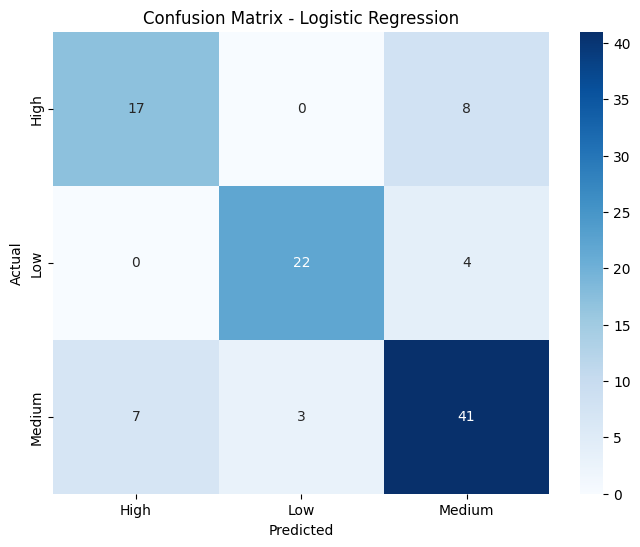

In [137]:
cm = confusion_matrix(y_test, y_pred_lgr)
cm_df = pd.DataFrame(cm, 
                     index=['High', 'Low', 'Medium'], 
                     columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [138]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = LgR.predict_proba(X_test)
classes = LgR.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


In [139]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [140]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
High     : 0.9138
Low      : 0.9717
Medium   : 0.8420
Micro-avg : 0.9189


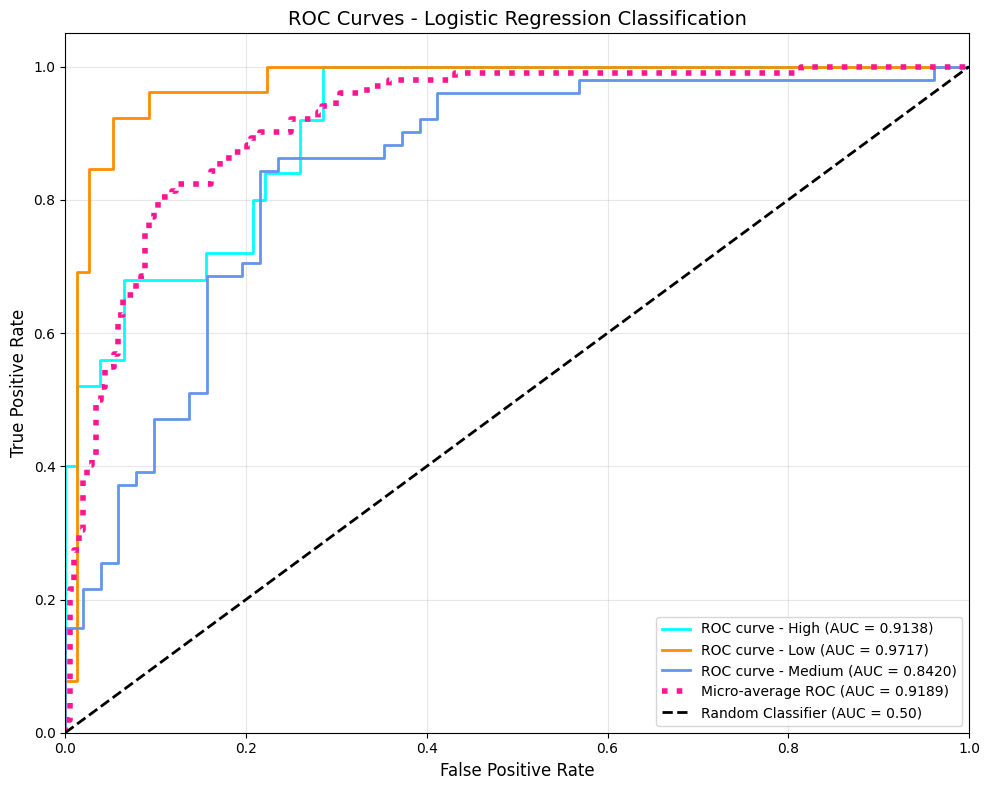

In [141]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [142]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.8926
One-vs-One (Weighted)  : 0.9082
Micro-average          : 0.9189


#### Random Forest Classifier

In [143]:
RFC = RandomForestClassifier(
    random_state=42,
    verbose=1  # Shows training progress
)
RFC

RandomForestClassifier(random_state=42, verbose=1)

In [144]:
%%time
RFC.fit(X_train, y_train)

CPU times: total: 312 ms
Wall time: 322 ms


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(random_state=42, verbose=1)

In [145]:
y_pred_rfc = RFC.predict(X_test)
y_pred_rfc

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array(['Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'High',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium',
       'High', 'Low', 'Low', 'Medium', 'Low', 'High', 'Low', 'Medium',
       'Medium

In [146]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [147]:
accuracy_RFC = accuracy_score(y_test, y_pred_rfc)
precision_RFC = precision_score(y_test, y_pred_rfc, average='weighted')
recall_RFC = recall_score(y_test, y_pred_rfc, average='weighted')
f1_RFC = f1_score(y_test, y_pred_rfc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Random Forest Classifier",
    model=RFC,
    scaler=scaler,
    accuracy=accuracy_RFC,
    precision=precision_RFC,
    recall=recall_RFC,
    f1=f1_RFC,
    parameters=RFC.get_params()
)

Random Forest Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\random_forest_classifier_standard_20250713_133249.pkl
    New scaler saved to: saved_models_classification\random_forest_classifier_scaler_standard_20250713_133249.pkl


True

In [148]:
print("RANDOM FOREST CLASSIFICATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_RFC:.4f}")
print(f"Precision: {precision_RFC:.4f}")
print(f"Recall:    {recall_RFC:.4f}")
print(f"F1-Score:  {f1_RFC:.4f}")

RANDOM FOREST CLASSIFICATION RESULTS
Accuracy:  0.8627
Precision: 0.8651
Recall:    0.8627
F1-Score:  0.8594


In [149]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_rfc))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        High       0.89      0.68      0.77        25
         Low       0.89      0.96      0.93        26
      Medium       0.84      0.90      0.87        51

    accuracy                           0.86       102
   macro avg       0.87      0.85      0.86       102
weighted avg       0.87      0.86      0.86       102



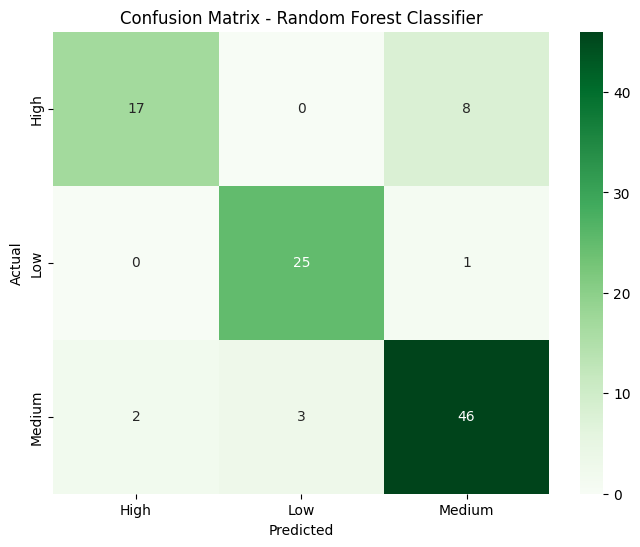

In [150]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cm_rfc_df = pd.DataFrame(cm_rfc, 
                         index=['High', 'Low', 'Medium'], 
                         columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc_df, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [151]:
# ROC and AUC Analysis for Random Forest Classifier
print("ROC CURVE AND AUC ANALYSIS - RANDOM FOREST")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba_rfc = RFC.predict_proba(X_test)
classes_rfc = RFC.classes_
n_classes_rfc = len(classes_rfc)

print(f"Classes: {classes_rfc}")
print(f"Prediction probabilities shape: {y_pred_proba_rfc.shape}")

ROC CURVE AND AUC ANALYSIS - RANDOM FOREST
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [152]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_rfc = label_binarize(y_test, classes=classes_rfc)

# Compute ROC curve and AUC for each class
fpr_rfc = dict()
tpr_rfc = dict()
roc_auc_rfc = dict()

for i in range(n_classes_rfc):
    fpr_rfc[i], tpr_rfc[i], _ = roc_curve(y_test_bin_rfc[:, i], y_pred_proba_rfc[:, i])
    roc_auc_rfc[i] = auc(fpr_rfc[i], tpr_rfc[i])

# Compute micro-average ROC curve and AUC
fpr_rfc["micro"], tpr_rfc["micro"], _ = roc_curve(y_test_bin_rfc.ravel(), y_pred_proba_rfc.ravel())
roc_auc_rfc["micro"] = auc(fpr_rfc["micro"], tpr_rfc["micro"])

In [153]:
# Print AUC scores for Random Forest
print("\nAUC SCORES - RANDOM FOREST:")
print("-" * 30)
for i, class_name in enumerate(classes_rfc):
    print(f"{class_name:8} : {roc_auc_rfc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_rfc['micro']:.4f}")


AUC SCORES - RANDOM FOREST:
------------------------------
High     : 0.9642
Low      : 0.9699
Medium   : 0.9216
Micro-avg : 0.9585


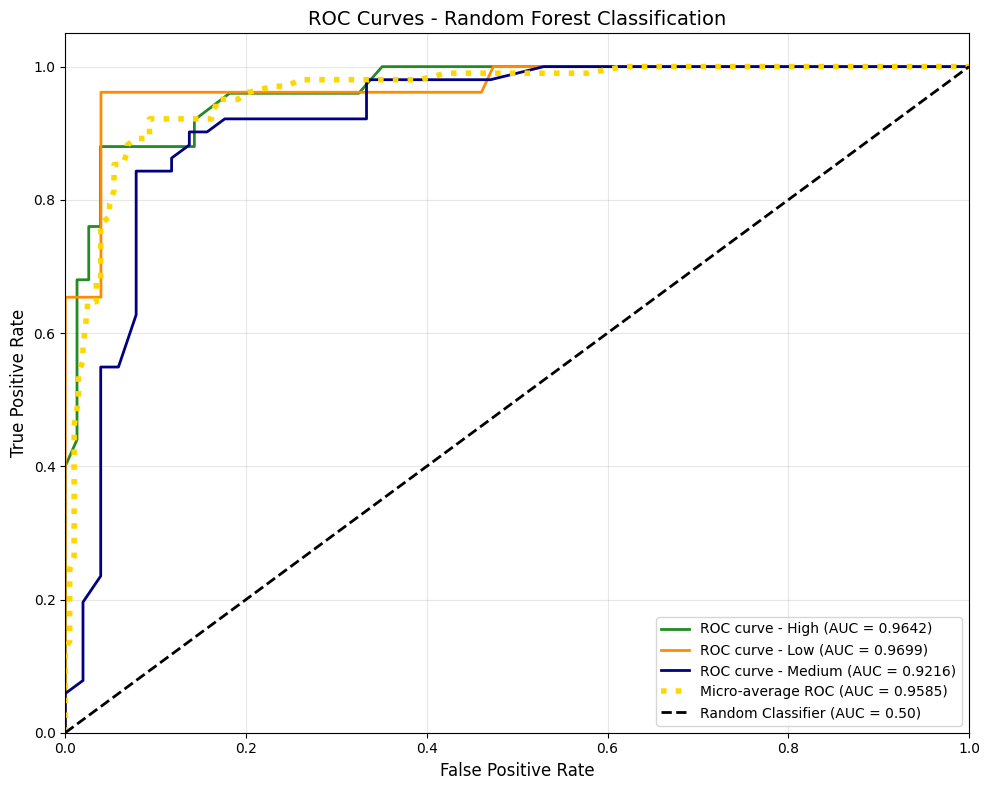

In [154]:
# Plot ROC curves for Random Forest
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['forestgreen', 'darkorange', 'navy'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_rfc), colors, classes_rfc):
    plt.plot(fpr_rfc[i], tpr_rfc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_rfc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_rfc["micro"], tpr_rfc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_rfc["micro"]:.4f})',
         color='gold', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Random Forest Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [155]:
# Calculate overall AUC scores using different methods for Random Forest
auc_ovr_rfc = roc_auc_score(y_test, y_pred_proba_rfc, multi_class='ovr', average='weighted')
auc_ovo_rfc = roc_auc_score(y_test, y_pred_proba_rfc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - RANDOM FOREST:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr_rfc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_rfc:.4f}")
print(f"Micro-average          : {roc_auc_rfc['micro']:.4f}")


OVERALL AUC SCORES - RANDOM FOREST:
------------------------------
One-vs-Rest (Weighted) : 0.9443
One-vs-One (Weighted)  : 0.9516
Micro-average          : 0.9585



FEATURE IMPORTANCE - RANDOM FOREST CLASSIFIER (TOP 10)
    feature  importance
5        RM    0.226036
12    LSTAT    0.184592
4       NOX    0.094094
0      CRIM    0.092707
7       DIS    0.091344
2     INDUS    0.065766
6       AGE    0.057235
11        B    0.051168
10  PTRATIO    0.049195
9       TAX    0.042012


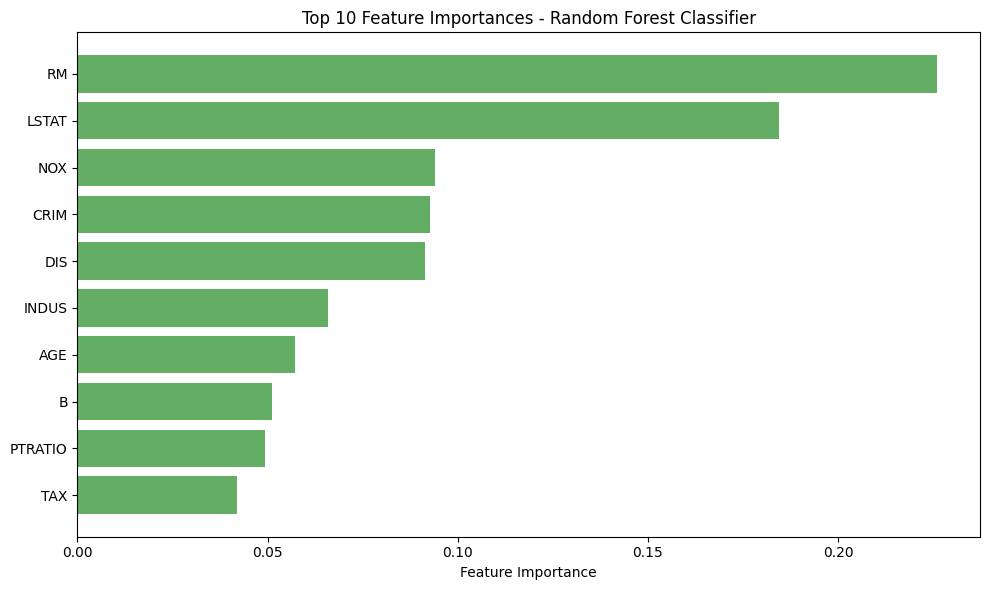

In [156]:
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_rfc = pd.DataFrame({
    'feature': feature_names,
    'importance': RFC.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - RANDOM FOREST CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_rfc.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_rfc.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Random Forest Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Support Vector Machine Classifier

In [157]:
SVC_model = SVC(
    random_state=42,
    verbose=True,  # Shows training progress
    probability=True  # Enable probability prediction for ROC analysis
)
SVC_model

SVC(probability=True, random_state=42, verbose=True)

In [158]:
%%time
SVC_model.fit(X_train, y_train)

[LibSVM]CPU times: total: 31.2 ms
Wall time: 44.5 ms


SVC(probability=True, random_state=42, verbose=True)

In [159]:
y_pred_svc = SVC_model.predict(X_test)
y_pred_svc

array(['Low', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'High', 'High',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'High', 'Medium', 'Low', 'Medium',
       'High', 'Low', 'Low', 'Medium', 'Low', 'High', 'Low', 'Medium',
       'Medium'

In [160]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [161]:
accuracy_SVC = accuracy_score(y_test, y_pred_svc)
precision_SVC = precision_score(y_test, y_pred_svc, average='weighted')
recall_SVC = recall_score(y_test, y_pred_svc, average='weighted')
f1_SVC = f1_score(y_test, y_pred_svc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="SVM Classifier",
    model=SVC_model,
    scaler=scaler,
    accuracy=accuracy_SVC,
    precision=precision_SVC,
    recall=recall_SVC,
    f1=f1_SVC,
    parameters=SVC_model.get_params()
)

SVM Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\svm_classifier_standard_20250713_133250.pkl
    New scaler saved to: saved_models_classification\svm_classifier_scaler_standard_20250713_133250.pkl


True

In [162]:
print("SVM CLASSIFICATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_SVC:.4f}")
print(f"Precision: {precision_SVC:.4f}")
print(f"Recall:    {recall_SVC:.4f}")
print(f"F1-Score:  {f1_SVC:.4f}")

SVM CLASSIFICATION RESULTS
Accuracy:  0.8137
Precision: 0.8115
Recall:    0.8137
F1-Score:  0.8109


In [163]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_svc))


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        High       0.76      0.64      0.70        25
         Low       0.89      0.92      0.91        26
      Medium       0.80      0.84      0.82        51

    accuracy                           0.81       102
   macro avg       0.82      0.80      0.81       102
weighted avg       0.81      0.81      0.81       102



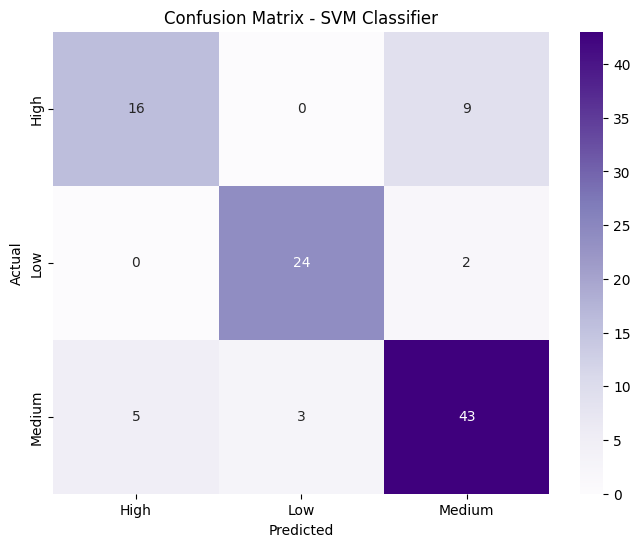

In [164]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_svc_df = pd.DataFrame(cm_svc, 
                         index=['High', 'Low', 'Medium'], 
                         columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc_df, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [165]:
# ROC and AUC Analysis for SVM Classifier
print("ROC CURVE AND AUC ANALYSIS - SVM CLASSIFIER")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba_svc = SVC_model.predict_proba(X_test)
classes_svc = SVC_model.classes_
n_classes_svc = len(classes_svc)

print(f"Classes: {classes_svc}")
print(f"Prediction probabilities shape: {y_pred_proba_svc.shape}")

ROC CURVE AND AUC ANALYSIS - SVM CLASSIFIER
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


In [166]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_svc = label_binarize(y_test, classes=classes_svc)

# Compute ROC curve and AUC for each class
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

for i in range(n_classes_svc):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_bin_svc[:, i], y_pred_proba_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

# Compute micro-average ROC curve and AUC
fpr_svc["micro"], tpr_svc["micro"], _ = roc_curve(y_test_bin_svc.ravel(), y_pred_proba_svc.ravel())
roc_auc_svc["micro"] = auc(fpr_svc["micro"], tpr_svc["micro"])

In [167]:
# Print AUC scores for SVM
print("\nAUC SCORES - SVM CLASSIFIER:")
print("-" * 30)
for i, class_name in enumerate(classes_svc):
    print(f"{class_name:8} : {roc_auc_svc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_svc['micro']:.4f}")


AUC SCORES - SVM CLASSIFIER:
------------------------------
High     : 0.9205
Low      : 0.9706
Medium   : 0.8704
Micro-avg : 0.9340


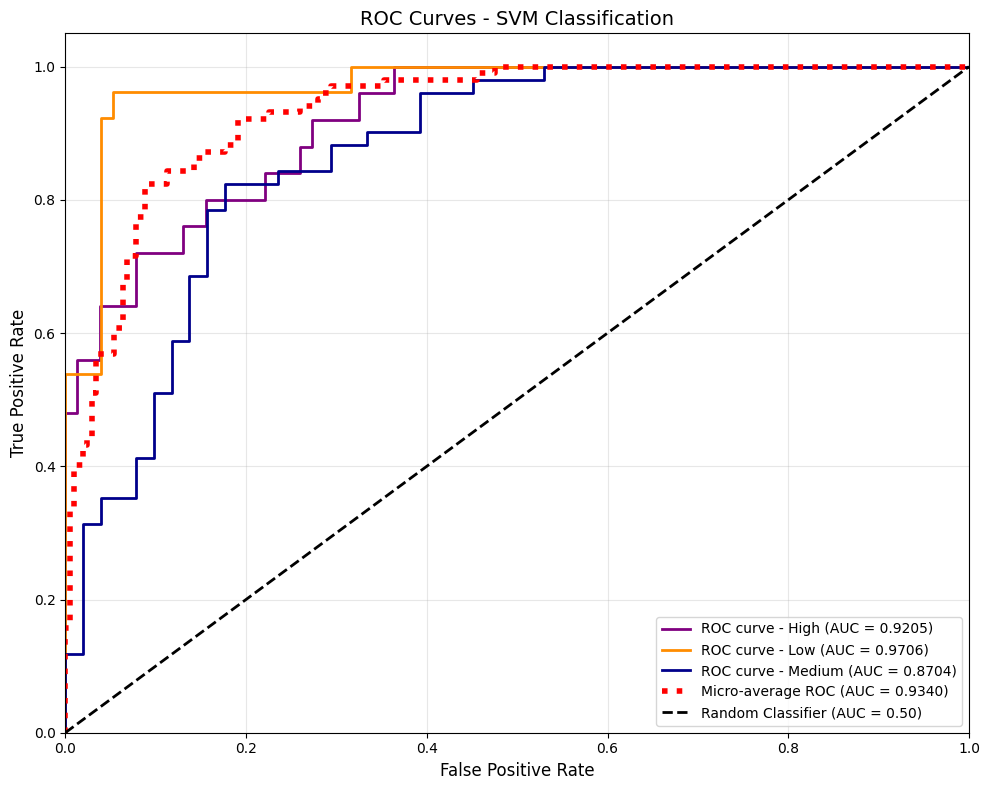

In [168]:
# Plot ROC curves for SVM
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['purple', 'darkorange', 'darkblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_svc), colors, classes_svc):
    plt.plot(fpr_svc[i], tpr_svc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_svc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_svc["micro"], tpr_svc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_svc["micro"]:.4f})',
         color='red', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - SVM Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [169]:
# Calculate overall AUC scores using different methods for SVM
auc_ovr_svc = roc_auc_score(y_test, y_pred_proba_svc, multi_class='ovr', average='weighted')
auc_ovo_svc = roc_auc_score(y_test, y_pred_proba_svc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - SVM CLASSIFIER:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr_svc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_svc:.4f}")
print(f"Micro-average          : {roc_auc_svc['micro']:.4f}")


OVERALL AUC SCORES - SVM CLASSIFIER:
------------------------------
One-vs-Rest (Weighted) : 0.9083
One-vs-One (Weighted)  : 0.9201
Micro-average          : 0.9340


### Bagging Ensamble Learning

#### Tuning Logistic Regression

In [170]:
# Create base Logistic Regression
base_lgr = LogisticRegression(random_state=42, max_iter=1000)

# Create Bagging Classifier
bagging_lgr_clf = BaggingClassifier(
    estimator=base_lgr,
    n_estimators=100,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_lgr_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=LogisticRegression(max_iter=1000, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [171]:
%%time
bagging_lgr_clf.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 46.9 ms
Wall time: 366 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


BaggingClassifier(bootstrap_features=True,
                  estimator=LogisticRegression(max_iter=1000, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [172]:
y_pred_bagging_lgr = bagging_lgr_clf.predict(X_test)
y_pred_bagging_lgr

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


array(['Low', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'High', 'Medium',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Low', 'High', 'High', 'Medium', 'Low', 'Medium',
       'Medium', 'Medium', 'High', 'Medium', 'Low', 'Medium', 'High',
       'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
     

In [173]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [174]:
accuracy_Bagging_LgR = accuracy_score(y_test, y_pred_bagging_lgr)
precision_Bagging_LgR = precision_score(y_test, y_pred_bagging_lgr, average='weighted')
recall_Bagging_LgR = recall_score(y_test, y_pred_bagging_lgr, average='weighted')
f1_Bagging_LgR = f1_score(y_test, y_pred_bagging_lgr, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Bagging Logistic Regression",
    model=bagging_lgr_clf,
    scaler=scaler,
    accuracy=accuracy_Bagging_LgR,
    precision=precision_Bagging_LgR,
    recall=recall_Bagging_LgR,
    f1=f1_Bagging_LgR,
    parameters=bagging_lgr_clf.get_params()
)

Bagging Logistic Regression (standard): First time training - saving model
    New model saved to: saved_models_classification\bagging_logistic_regression_standard_20250713_133251.pkl
    New scaler saved to: saved_models_classification\bagging_logistic_regression_scaler_standard_20250713_133251.pkl


True

In [175]:
print("BAGGING LOGISTIC REGRESSION CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Bagging_LgR:.4f}")
print(f"Precision: {precision_Bagging_LgR:.4f}")
print(f"Recall:    {recall_Bagging_LgR:.4f}")
print(f"F1-Score:  {f1_Bagging_LgR:.4f}")

BAGGING LOGISTIC REGRESSION CLASSIFICATION RESULTS
Accuracy:  0.7745
Precision: 0.7783
Recall:    0.7745
F1-Score:  0.7715


In [176]:
print("\nDETAILED CLASSIFICATION REPORT - BAGGING LOGISTIC REGRESSION")
print("="*60)
print(classification_report(y_test, y_pred_bagging_lgr))


DETAILED CLASSIFICATION REPORT - BAGGING LOGISTIC REGRESSION
              precision    recall  f1-score   support

        High       0.79      0.60      0.68        25
         Low       0.84      0.81      0.82        26
      Medium       0.74      0.84      0.79        51

    accuracy                           0.77       102
   macro avg       0.79      0.75      0.76       102
weighted avg       0.78      0.77      0.77       102



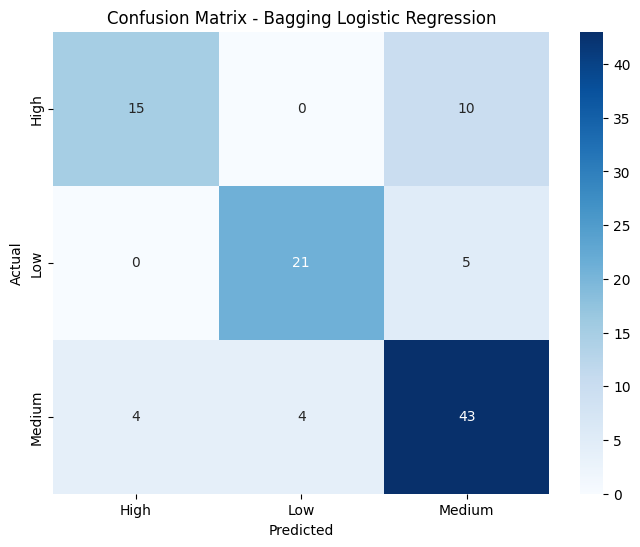

In [177]:
# Confusion Matrix
cm_bagging_lgr = confusion_matrix(y_test, y_pred_bagging_lgr)
cm_bagging_lgr_df = pd.DataFrame(cm_bagging_lgr, 
                                index=['High', 'Low', 'Medium'], 
                                columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging_lgr_df, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Bagging Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [178]:
# ROC and AUC Analysis for Bagging Logistic Regression
print("ROC CURVE AND AUC ANALYSIS - BAGGING LOGISTIC REGRESSION")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_bagging_lgr = bagging_lgr_clf.predict_proba(X_test)
classes_bagging_lgr = bagging_lgr_clf.classes_
n_classes_bagging_lgr = len(classes_bagging_lgr)

print(f"Classes: {classes_bagging_lgr}")
print(f"Prediction probabilities shape: {y_pred_proba_bagging_lgr.shape}")

ROC CURVE AND AUC ANALYSIS - BAGGING LOGISTIC REGRESSION
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [179]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_bagging_lgr = label_binarize(y_test, classes=classes_bagging_lgr)

# Compute ROC curve and AUC for each class
fpr_bagging_lgr = dict()
tpr_bagging_lgr = dict()
roc_auc_bagging_lgr = dict()

for i in range(n_classes_bagging_lgr):
    fpr_bagging_lgr[i], tpr_bagging_lgr[i], _ = roc_curve(y_test_bin_bagging_lgr[:, i], y_pred_proba_bagging_lgr[:, i])
    roc_auc_bagging_lgr[i] = auc(fpr_bagging_lgr[i], tpr_bagging_lgr[i])

# Compute micro-average ROC curve and AUC
fpr_bagging_lgr["micro"], tpr_bagging_lgr["micro"], _ = roc_curve(y_test_bin_bagging_lgr.ravel(), y_pred_proba_bagging_lgr.ravel())
roc_auc_bagging_lgr["micro"] = auc(fpr_bagging_lgr["micro"], tpr_bagging_lgr["micro"])

In [180]:
# Print AUC scores for Bagging Logistic Regression
print("\nAUC SCORES - BAGGING LOGISTIC REGRESSION:")
print("-" * 40)
for i, class_name in enumerate(classes_bagging_lgr):
    print(f"{class_name:8} : {roc_auc_bagging_lgr[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_bagging_lgr['micro']:.4f}")


AUC SCORES - BAGGING LOGISTIC REGRESSION:
----------------------------------------
High     : 0.9231
Low      : 0.9626
Medium   : 0.8470
Micro-avg : 0.9216


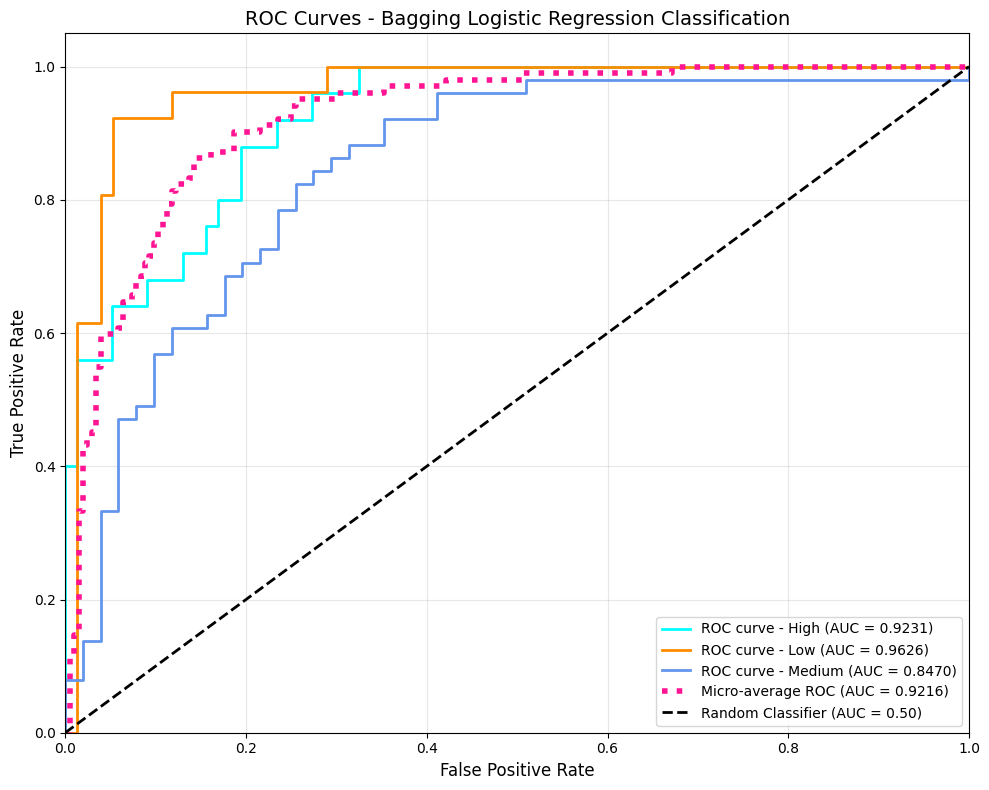

In [181]:
# Plot ROC curves for Bagging Logistic Regression
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_bagging_lgr), colors, classes_bagging_lgr):
    plt.plot(fpr_bagging_lgr[i], tpr_bagging_lgr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_bagging_lgr[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_bagging_lgr["micro"], tpr_bagging_lgr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_bagging_lgr["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Bagging Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [182]:
# Calculate overall AUC scores
auc_ovr_bagging_lgr = roc_auc_score(y_test, y_pred_proba_bagging_lgr, multi_class='ovr', average='weighted')
auc_ovo_bagging_lgr = roc_auc_score(y_test, y_pred_proba_bagging_lgr, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - BAGGING LOGISTIC REGRESSION:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_bagging_lgr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_bagging_lgr:.4f}")
print(f"Micro-average          : {roc_auc_bagging_lgr['micro']:.4f}")


OVERALL AUC SCORES - BAGGING LOGISTIC REGRESSION:
----------------------------------------
One-vs-Rest (Weighted) : 0.8951
One-vs-One (Weighted)  : 0.9102
Micro-average          : 0.9216


#### Tuning Random Forest Classifier

In [183]:
# Create base Random Forest Classifier
base_rfc = RandomForestClassifier(random_state=42, verbose=1)

# Create Bagging Classifier with Random Forest
bagging_rfc_clf = BaggingClassifier(
    estimator=base_rfc,
    n_estimators=50,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8,
    max_samples=0.8
)

bagging_rfc_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42, verbose=1),
                  max_features=0.8, max_samples=0.8, n_estimators=50, n_jobs=-1,
                  random_state=42, verbose=1)

In [184]:
%%time
bagging_rfc_clf.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.1s


CPU times: total: 625 ms
Wall time: 2.52 s


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(random_state=42, verbose=1),
                  max_features=0.8, max_samples=0.8, n_estimators=50, n_jobs=-1,
                  random_state=42, verbose=1)

In [185]:
y_pred_bagging_rfc = bagging_rfc_clf.predict(X_test)
y_pred_bagging_rfc

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished


array(['Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'High',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'High', 'High', 'Low', 'Low',
       'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High', 'Medium',
       'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low', 'High',
       'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High',
       'Medium', 'Medium', 'High', 'High', 'Medium', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'High',
       'Low', 'Low', 'Medium', 'Low', 'High', 'Low', 'Medium', 'Medium'],
  

In [186]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [187]:
accuracy_Bagging_RFC = accuracy_score(y_test, y_pred_bagging_rfc)
precision_Bagging_RFC = precision_score(y_test, y_pred_bagging_rfc, average='weighted')
recall_Bagging_RFC = recall_score(y_test, y_pred_bagging_rfc, average='weighted')
f1_Bagging_RFC = f1_score(y_test, y_pred_bagging_rfc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Bagging Random Forest Classifier",
    model=bagging_rfc_clf,
    scaler=scaler,
    accuracy=accuracy_Bagging_RFC,
    precision=precision_Bagging_RFC,
    recall=recall_Bagging_RFC,
    f1=f1_Bagging_RFC,
    parameters=bagging_rfc_clf.get_params()
)

Bagging Random Forest Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\bagging_random_forest_classifier_standard_20250713_133257.pkl
    New scaler saved to: saved_models_classification\bagging_random_forest_classifier_scaler_standard_20250713_133257.pkl


True

In [188]:
print("BAGGING RANDOM FOREST CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Bagging_RFC:.4f}")
print(f"Precision: {precision_Bagging_RFC:.4f}")
print(f"Recall:    {recall_Bagging_RFC:.4f}")
print(f"F1-Score:  {f1_Bagging_RFC:.4f}")

BAGGING RANDOM FOREST CLASSIFICATION RESULTS
Accuracy:  0.8431
Precision: 0.8440
Recall:    0.8431
F1-Score:  0.8406


In [189]:
print("\nDETAILED CLASSIFICATION REPORT - BAGGING RANDOM FOREST")
print("="*60)
print(classification_report(y_test, y_pred_bagging_rfc))


DETAILED CLASSIFICATION REPORT - BAGGING RANDOM FOREST
              precision    recall  f1-score   support

        High       0.85      0.68      0.76        25
         Low       0.89      0.92      0.91        26
      Medium       0.82      0.88      0.85        51

    accuracy                           0.84       102
   macro avg       0.85      0.83      0.84       102
weighted avg       0.84      0.84      0.84       102



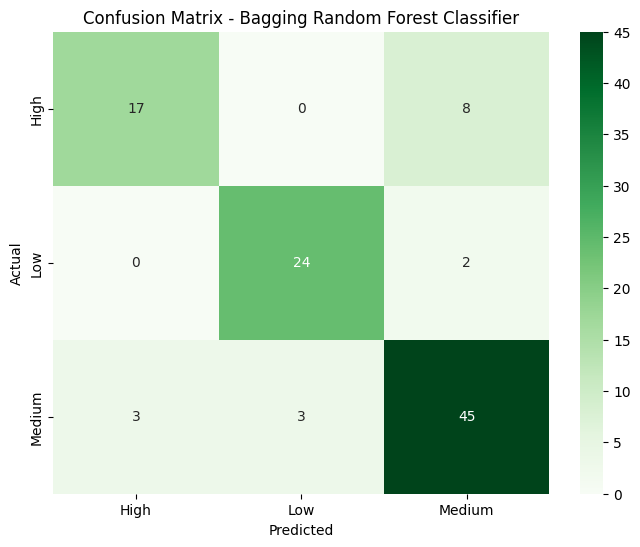

In [190]:
# Confusion Matrix
cm_bagging_rfc = confusion_matrix(y_test, y_pred_bagging_rfc)
cm_bagging_rfc_df = pd.DataFrame(cm_bagging_rfc, 
                                index=['High', 'Low', 'Medium'], 
                                columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging_rfc_df, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Bagging Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [191]:
# ROC and AUC Analysis for Bagging Random Forest Classifier
print("ROC CURVE AND AUC ANALYSIS - BAGGING RANDOM FOREST")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_bagging_rfc = bagging_rfc_clf.predict_proba(X_test)
classes_bagging_rfc = bagging_rfc_clf.classes_
n_classes_bagging_rfc = len(classes_bagging_rfc)

print(f"Classes: {classes_bagging_rfc}")
print(f"Prediction probabilities shape: {y_pred_proba_bagging_rfc.shape}")

ROC CURVE AND AUC ANALYSIS - BAGGING RANDOM FOREST


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    2.0s


Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished


In [192]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_bagging_rfc = label_binarize(y_test, classes=classes_bagging_rfc)

# Compute ROC curve and AUC for each class
fpr_bagging_rfc = dict()
tpr_bagging_rfc = dict()
roc_auc_bagging_rfc = dict()

for i in range(n_classes_bagging_rfc):
    fpr_bagging_rfc[i], tpr_bagging_rfc[i], _ = roc_curve(y_test_bin_bagging_rfc[:, i], y_pred_proba_bagging_rfc[:, i])
    roc_auc_bagging_rfc[i] = auc(fpr_bagging_rfc[i], tpr_bagging_rfc[i])

# Compute micro-average ROC curve and AUC
fpr_bagging_rfc["micro"], tpr_bagging_rfc["micro"], _ = roc_curve(y_test_bin_bagging_rfc.ravel(), y_pred_proba_bagging_rfc.ravel())
roc_auc_bagging_rfc["micro"] = auc(fpr_bagging_rfc["micro"], tpr_bagging_rfc["micro"])

In [193]:
# Print AUC scores for Bagging Random Forest
print("\nAUC SCORES - BAGGING RANDOM FOREST:")
print("-" * 40)
for i, class_name in enumerate(classes_bagging_rfc):
    print(f"{class_name:8} : {roc_auc_bagging_rfc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_bagging_rfc['micro']:.4f}")


AUC SCORES - BAGGING RANDOM FOREST:
----------------------------------------
High     : 0.9512
Low      : 0.9686
Medium   : 0.9020
Micro-avg : 0.9498


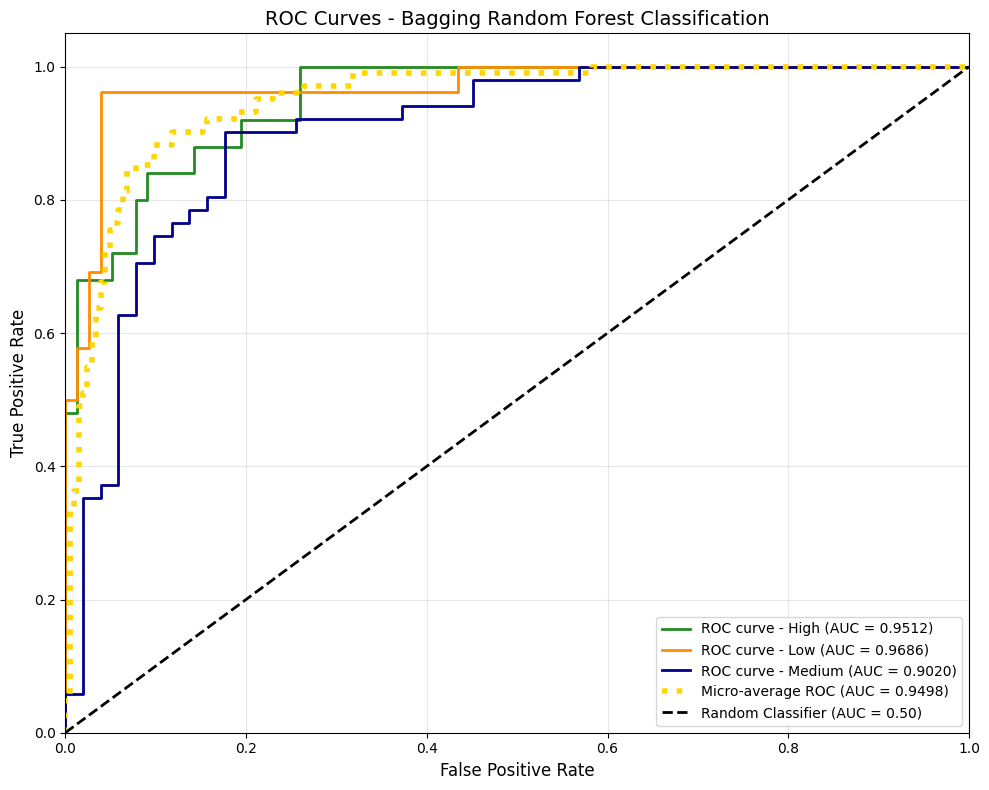

In [194]:
# Plot ROC curves for Bagging Random Forest
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['forestgreen', 'darkorange', 'darkblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_bagging_rfc), colors, classes_bagging_rfc):
    plt.plot(fpr_bagging_rfc[i], tpr_bagging_rfc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_bagging_rfc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_bagging_rfc["micro"], tpr_bagging_rfc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_bagging_rfc["micro"]:.4f})',
         color='gold', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Bagging Random Forest Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [195]:
# Calculate overall AUC scores
auc_ovr_bagging_rfc = roc_auc_score(y_test, y_pred_proba_bagging_rfc, multi_class='ovr', average='weighted')
auc_ovo_bagging_rfc = roc_auc_score(y_test, y_pred_proba_bagging_rfc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - BAGGING RANDOM FOREST:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_bagging_rfc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_bagging_rfc:.4f}")
print(f"Micro-average          : {roc_auc_bagging_rfc['micro']:.4f}")


OVERALL AUC SCORES - BAGGING RANDOM FOREST:
----------------------------------------
One-vs-Rest (Weighted) : 0.9310
One-vs-One (Weighted)  : 0.9403
Micro-average          : 0.9498


#### Tuning Support Vector Machine Classifier

In [196]:
# Create base Support Vector Classifier
base_svc = SVC(random_state=42, probability=True, verbose=True)

# Create Bagging Classifier with SVM
bagging_svc_clf = BaggingClassifier(
    estimator=base_svc,
    n_estimators=50,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8,
    max_samples=0.8
)

bagging_svc_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42,
                                verbose=True),
                  max_features=0.8, max_samples=0.8, n_estimators=50, n_jobs=-1,
                  random_state=42, verbose=1)

In [197]:
%%time
bagging_svc_clf.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


CPU times: total: 15.6 ms
Wall time: 374 ms


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42,
                                verbose=True),
                  max_features=0.8, max_samples=0.8, n_estimators=50, n_jobs=-1,
                  random_state=42, verbose=1)

In [198]:
y_pred_bagging_svc = bagging_svc_clf.predict(X_test)
y_pred_bagging_svc

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


array(['Low', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'High', 'Medium', 'Medium', 'Medium', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'High', 'Medium',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'Low', 'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium',
       'Low', 'High', 'High', 'Medium', 'High', 'Medium', 'Medium',
       'Medium', 'High', 'Medium', 'Low', 'High', 'High', 'Medium',
       'Medium', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'Low',
       'Medium', 'High', 'Low', 'Low', 'Medium', 'Low', 'High', 'Medium',
       'M

In [199]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [200]:
accuracy_Bagging_SVC = accuracy_score(y_test, y_pred_bagging_svc)
precision_Bagging_SVC = precision_score(y_test, y_pred_bagging_svc, average='weighted')
recall_Bagging_SVC = recall_score(y_test, y_pred_bagging_svc, average='weighted')
f1_Bagging_SVC = f1_score(y_test, y_pred_bagging_svc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Bagging SVM Classifier",
    model=bagging_svc_clf,
    scaler=scaler,
    accuracy=accuracy_Bagging_SVC,
    precision=precision_Bagging_SVC,
    recall=recall_Bagging_SVC,
    f1=f1_Bagging_SVC,
    parameters=bagging_svc_clf.get_params()
)

Bagging SVM Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\bagging_svm_classifier_standard_20250713_133304.pkl
    New scaler saved to: saved_models_classification\bagging_svm_classifier_scaler_standard_20250713_133304.pkl


True

In [201]:
print("BAGGING SVM CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Bagging_SVC:.4f}")
print(f"Precision: {precision_Bagging_SVC:.4f}")
print(f"Recall:    {recall_Bagging_SVC:.4f}")
print(f"F1-Score:  {f1_Bagging_SVC:.4f}")

BAGGING SVM CLASSIFICATION RESULTS
Accuracy:  0.7549
Precision: 0.7624
Recall:    0.7549
F1-Score:  0.7522


In [202]:
print("\nDETAILED CLASSIFICATION REPORT - BAGGING SVM")
print("="*60)
print(classification_report(y_test, y_pred_bagging_svc))


DETAILED CLASSIFICATION REPORT - BAGGING SVM
              precision    recall  f1-score   support

        High       0.79      0.60      0.68        25
         Low       0.83      0.73      0.78        26
      Medium       0.72      0.84      0.77        51

    accuracy                           0.75       102
   macro avg       0.78      0.72      0.74       102
weighted avg       0.76      0.75      0.75       102



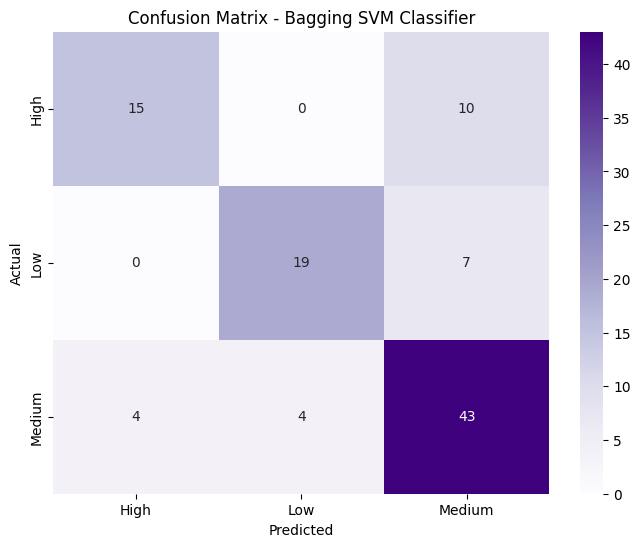

In [203]:
# Confusion Matrix
cm_bagging_svc = confusion_matrix(y_test, y_pred_bagging_svc)
cm_bagging_svc_df = pd.DataFrame(cm_bagging_svc, 
                                index=['High', 'Low', 'Medium'], 
                                columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging_svc_df, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Bagging SVM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [204]:
# ROC and AUC Analysis for Bagging SVM Classifier
print("ROC CURVE AND AUC ANALYSIS - BAGGING SVM")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_bagging_svc = bagging_svc_clf.predict_proba(X_test)
classes_bagging_svc = bagging_svc_clf.classes_
n_classes_bagging_svc = len(classes_bagging_svc)

print(f"Classes: {classes_bagging_svc}")
print(f"Prediction probabilities shape: {y_pred_proba_bagging_svc.shape}")

ROC CURVE AND AUC ANALYSIS - BAGGING SVM
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [205]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_bagging_svc = label_binarize(y_test, classes=classes_bagging_svc)

# Compute ROC curve and AUC for each class
fpr_bagging_svc = dict()
tpr_bagging_svc = dict()
roc_auc_bagging_svc = dict()

for i in range(n_classes_bagging_svc):
    fpr_bagging_svc[i], tpr_bagging_svc[i], _ = roc_curve(y_test_bin_bagging_svc[:, i], y_pred_proba_bagging_svc[:, i])
    roc_auc_bagging_svc[i] = auc(fpr_bagging_svc[i], tpr_bagging_svc[i])

# Compute micro-average ROC curve and AUC
fpr_bagging_svc["micro"], tpr_bagging_svc["micro"], _ = roc_curve(y_test_bin_bagging_svc.ravel(), y_pred_proba_bagging_svc.ravel())
roc_auc_bagging_svc["micro"] = auc(fpr_bagging_svc["micro"], tpr_bagging_svc["micro"])

In [206]:
# Print AUC scores for Bagging SVM
print("\nAUC SCORES - BAGGING SVM:")
print("-" * 40)
for i, class_name in enumerate(classes_bagging_svc):
    print(f"{class_name:8} : {roc_auc_bagging_svc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_bagging_svc['micro']:.4f}")


AUC SCORES - BAGGING SVM:
----------------------------------------
High     : 0.9195
Low      : 0.9641
Medium   : 0.8474
Micro-avg : 0.9215


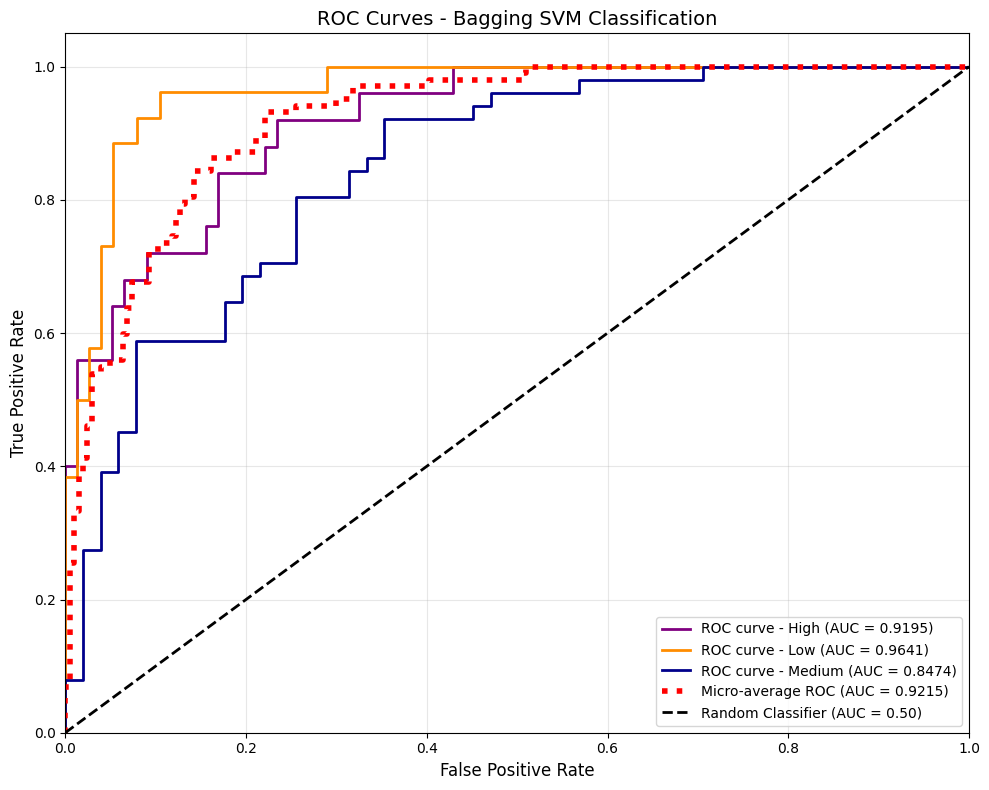

In [207]:
# Plot ROC curves for Bagging SVM
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['purple', 'darkorange', 'darkblue'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_bagging_svc), colors, classes_bagging_svc):
    plt.plot(fpr_bagging_svc[i], tpr_bagging_svc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_bagging_svc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_bagging_svc["micro"], tpr_bagging_svc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_bagging_svc["micro"]:.4f})',
         color='red', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Bagging SVM Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [208]:
# Calculate overall AUC scores
auc_ovr_bagging_svc = roc_auc_score(y_test, y_pred_proba_bagging_svc, multi_class='ovr', average='weighted')
auc_ovo_bagging_svc = roc_auc_score(y_test, y_pred_proba_bagging_svc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - BAGGING SVM:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_bagging_svc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_bagging_svc:.4f}")
print(f"Micro-average          : {roc_auc_bagging_svc['micro']:.4f}")


OVERALL AUC SCORES - BAGGING SVM:
----------------------------------------
One-vs-Rest (Weighted) : 0.8948
One-vs-One (Weighted)  : 0.9096
Micro-average          : 0.9215


### Gradient Boosting

In [209]:
# Create Gradient Boosting Classifier
GBC = GradientBoostingClassifier(
    random_state=42,
    verbose=1  # Shows training progress
)
GBC

GradientBoostingClassifier(random_state=42, verbose=1)

In [210]:
%%time
GBC.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9100            1.27s
         2           0.8118            1.10s
         3           0.7342            1.05s
         4           0.6717            1.04s
         5           0.6173            1.00s
         6           0.5718            0.97s
         7           0.5329            0.95s
         8           0.4989            0.93s
         9           0.4690            0.91s
        10           0.4428            0.90s
        20           0.2854            0.76s
        30           0.2128            0.65s
        40           0.1708            0.56s
        50           0.1360            0.47s
        60           0.1103            0.38s
        70           0.0917            0.28s
        80           0.0776            0.19s
        90           0.0660            0.09s
       100           0.0557            0.00s
CPU times: total: 922 ms
Wall time: 934 ms


GradientBoostingClassifier(random_state=42, verbose=1)

In [211]:
y_pred_gbc = GBC.predict(X_test)
y_pred_gbc

array(['Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'High',
       'Medium', 'High', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'High',
       'Medium', 'Low', 'High', 'Low', 'High', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium',
       'High', 'Low', 'Medium', 'Medium', 'Low', 'High', 'Low', 'Medium',
       'Mediu

In [212]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [213]:
accuracy_GBC = accuracy_score(y_test, y_pred_gbc)
precision_GBC = precision_score(y_test, y_pred_gbc, average='weighted')
recall_GBC = recall_score(y_test, y_pred_gbc, average='weighted')
f1_GBC = f1_score(y_test, y_pred_gbc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Gradient Boosting Classifier",
    model=GBC,
    scaler=scaler,
    accuracy=accuracy_GBC,
    precision=precision_GBC,
    recall=recall_GBC,
    f1=f1_GBC,
    parameters=GBC.get_params()
)

Gradient Boosting Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\gradient_boosting_classifier_standard_20250713_133306.pkl
    New scaler saved to: saved_models_classification\gradient_boosting_classifier_scaler_standard_20250713_133306.pkl


True

In [214]:
print("GRADIENT BOOSTING CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_GBC:.4f}")
print(f"Precision: {precision_GBC:.4f}")
print(f"Recall:    {recall_GBC:.4f}")
print(f"F1-Score:  {f1_GBC:.4f}")

GRADIENT BOOSTING CLASSIFICATION RESULTS
Accuracy:  0.8824
Precision: 0.8867
Recall:    0.8824
F1-Score:  0.8812


In [215]:
print("\nDETAILED CLASSIFICATION REPORT - GRADIENT BOOSTING")
print("="*60)
print(classification_report(y_test, y_pred_gbc))


DETAILED CLASSIFICATION REPORT - GRADIENT BOOSTING
              precision    recall  f1-score   support

        High       0.95      0.76      0.84        25
         Low       0.89      0.92      0.91        26
      Medium       0.85      0.92      0.89        51

    accuracy                           0.88       102
   macro avg       0.90      0.87      0.88       102
weighted avg       0.89      0.88      0.88       102



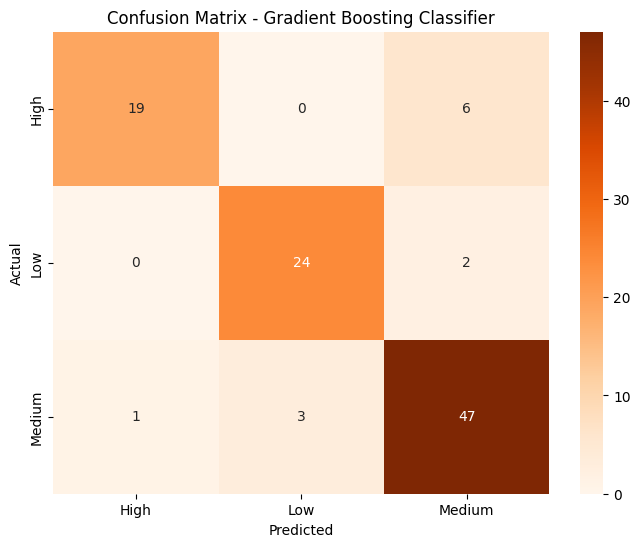

In [216]:
# Confusion Matrix
cm_gbc = confusion_matrix(y_test, y_pred_gbc)
cm_gbc_df = pd.DataFrame(cm_gbc, 
                        index=['High', 'Low', 'Medium'], 
                        columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbc_df, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [217]:
# ROC and AUC Analysis for Gradient Boosting Classifier
print("ROC CURVE AND AUC ANALYSIS - GRADIENT BOOSTING")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_gbc = GBC.predict_proba(X_test)
classes_gbc = GBC.classes_
n_classes_gbc = len(classes_gbc)

print(f"Classes: {classes_gbc}")
print(f"Prediction probabilities shape: {y_pred_proba_gbc.shape}")

ROC CURVE AND AUC ANALYSIS - GRADIENT BOOSTING
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


In [218]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_gbc = label_binarize(y_test, classes=classes_gbc)

# Compute ROC curve and AUC for each class
fpr_gbc = dict()
tpr_gbc = dict()
roc_auc_gbc = dict()

for i in range(n_classes_gbc):
    fpr_gbc[i], tpr_gbc[i], _ = roc_curve(y_test_bin_gbc[:, i], y_pred_proba_gbc[:, i])
    roc_auc_gbc[i] = auc(fpr_gbc[i], tpr_gbc[i])

# Compute micro-average ROC curve and AUC
fpr_gbc["micro"], tpr_gbc["micro"], _ = roc_curve(y_test_bin_gbc.ravel(), y_pred_proba_gbc.ravel())
roc_auc_gbc["micro"] = auc(fpr_gbc["micro"], tpr_gbc["micro"])

In [219]:
# Print AUC scores for Gradient Boosting
print("\nAUC SCORES - GRADIENT BOOSTING:")
print("-" * 40)
for i, class_name in enumerate(classes_gbc):
    print(f"{class_name:8} : {roc_auc_gbc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_gbc['micro']:.4f}")


AUC SCORES - GRADIENT BOOSTING:
----------------------------------------
High     : 0.9782
Low      : 0.9620
Medium   : 0.9362
Micro-avg : 0.9641


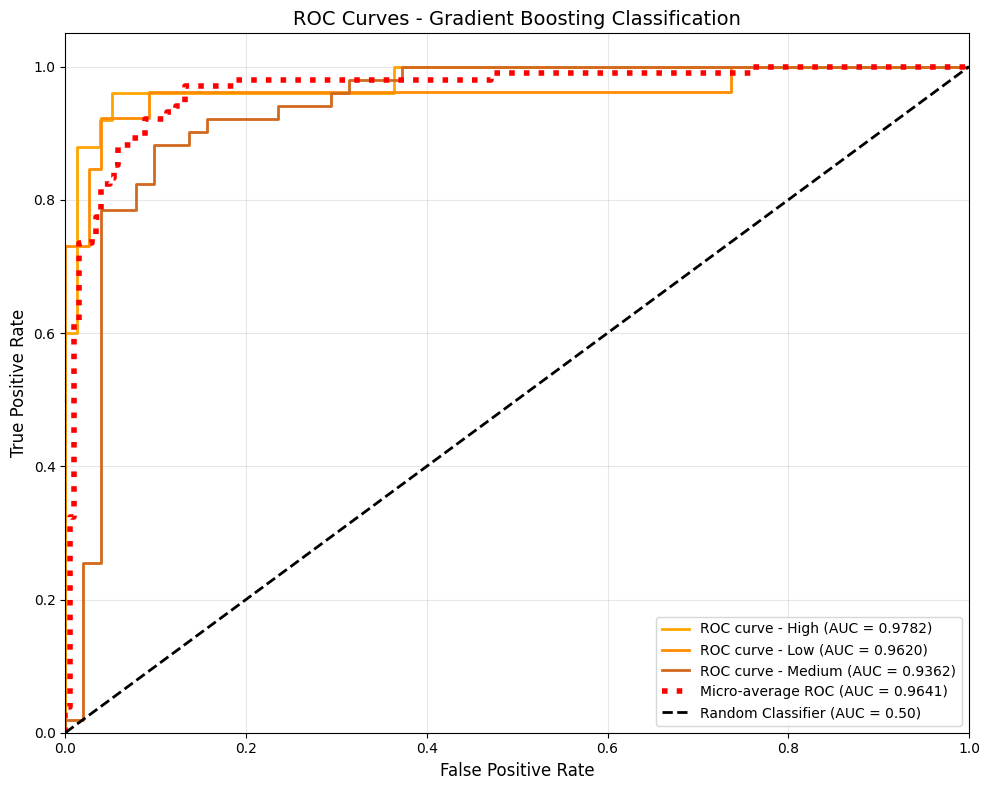

In [220]:
# Plot ROC curves for Gradient Boosting
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['orange', 'darkorange', 'chocolate'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_gbc), colors, classes_gbc):
    plt.plot(fpr_gbc[i], tpr_gbc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_gbc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_gbc["micro"], tpr_gbc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_gbc["micro"]:.4f})',
         color='red', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Gradient Boosting Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [221]:
# Calculate overall AUC scores using different methods for Gradient Boosting
auc_ovr_gbc = roc_auc_score(y_test, y_pred_proba_gbc, multi_class='ovr', average='weighted')
auc_ovo_gbc = roc_auc_score(y_test, y_pred_proba_gbc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - GRADIENT BOOSTING:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_gbc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_gbc:.4f}")
print(f"Micro-average          : {roc_auc_gbc['micro']:.4f}")


OVERALL AUC SCORES - GRADIENT BOOSTING:
----------------------------------------
One-vs-Rest (Weighted) : 0.9531
One-vs-One (Weighted)  : 0.9587
Micro-average          : 0.9641



FEATURE IMPORTANCE - GRADIENT BOOSTING CLASSIFIER (TOP 10)
    feature  importance
5        RM    0.325281
12    LSTAT    0.261430
7       DIS    0.137028
0      CRIM    0.090214
4       NOX    0.047877
10  PTRATIO    0.040933
11        B    0.031553
9       TAX    0.028628
2     INDUS    0.015307
6       AGE    0.011107


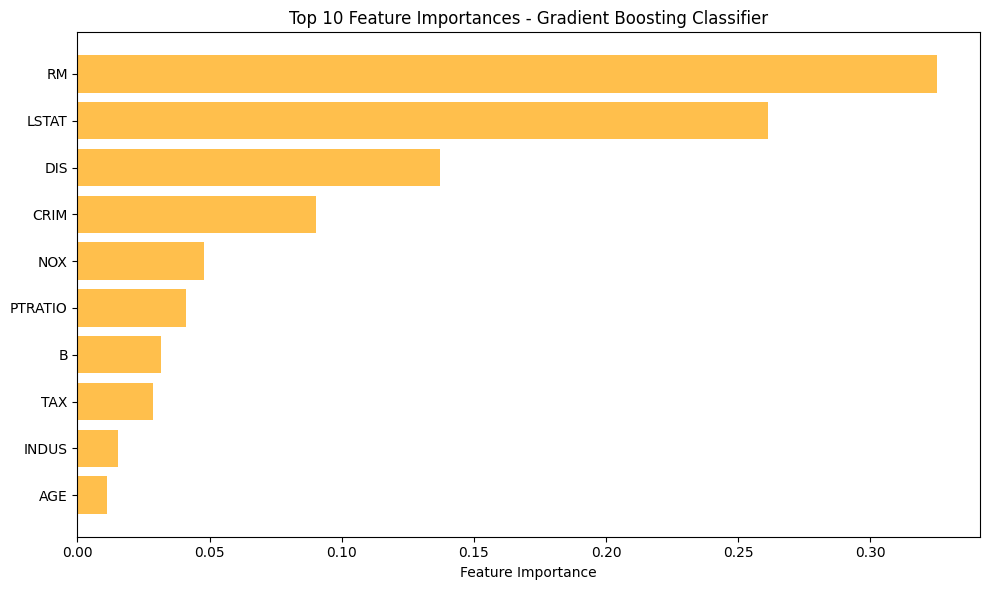

In [222]:
# Feature Importance for Gradient Boosting
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_gbc = pd.DataFrame({
    'feature': feature_names,
    'importance': GBC.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - GRADIENT BOOSTING CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_gbc.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_gbc.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='orange', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Gradient Boosting Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### AdaBoost

In [223]:
# Create AdaBoost Classifier
ABC = AdaBoostClassifier(random_state=42)
ABC

AdaBoostClassifier(random_state=42)

In [224]:
%%time
ABC.fit(X_train, y_train)

CPU times: total: 172 ms
Wall time: 172 ms


AdaBoostClassifier(random_state=42)

In [225]:
y_pred_abc = ABC.predict(X_test)
y_pred_abc

array(['Low', 'High', 'Low', 'Medium', 'Medium', 'Medium', 'High', 'High',
       'High', 'Medium', 'High', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Low', 'Low', 'Low',
       'Medium', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'High', 'Low', 'Low', 'High', 'High', 'Medium', 'Low', 'High',
       'Low', 'Medium', 'High', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Medium', 'Medium', 'High', 'Low', 'Low', 'Medium',
       'Medium', 'Medium', 'High', 'Medium', 'High', 'Medium', 'Low',
       'Medium', 'Medium', 'Low', 'Low', 'Medium', 'Low', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Low', 'High', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Medium',
       'Low', 'High', 'High', 'Medium', 'Medium', 'High', 'Medium',
       'High', 'Medium', 'Medium', 'Low', 'Medium', 'High', 'Low', 'Low',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'Medium'], dtype=object)

In [226]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [227]:
accuracy_ABC = accuracy_score(y_test, y_pred_abc)
precision_ABC = precision_score(y_test, y_pred_abc, average='weighted')
recall_ABC = recall_score(y_test, y_pred_abc, average='weighted')
f1_ABC = f1_score(y_test, y_pred_abc, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="AdaBoost Classifier",
    model=ABC,
    scaler=scaler,
    accuracy=accuracy_ABC,
    precision=precision_ABC,
    recall=recall_ABC,
    f1=f1_ABC,
    parameters=ABC.get_params()
)

AdaBoost Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\adaboost_classifier_standard_20250713_133307.pkl
    New scaler saved to: saved_models_classification\adaboost_classifier_scaler_standard_20250713_133307.pkl


True

In [228]:
print("ADABOOST CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_ABC:.4f}")
print(f"Precision: {precision_ABC:.4f}")
print(f"Recall:    {recall_ABC:.4f}")
print(f"F1-Score:  {f1_ABC:.4f}")

ADABOOST CLASSIFICATION RESULTS
Accuracy:  0.7843
Precision: 0.7845
Recall:    0.7843
F1-Score:  0.7840


In [229]:
print("\nDETAILED CLASSIFICATION REPORT - ADABOOST")
print("="*60)
print(classification_report(y_test, y_pred_abc))


DETAILED CLASSIFICATION REPORT - ADABOOST
              precision    recall  f1-score   support

        High       0.76      0.76      0.76        25
         Low       0.79      0.85      0.81        26
      Medium       0.80      0.76      0.78        51

    accuracy                           0.78       102
   macro avg       0.78      0.79      0.78       102
weighted avg       0.78      0.78      0.78       102



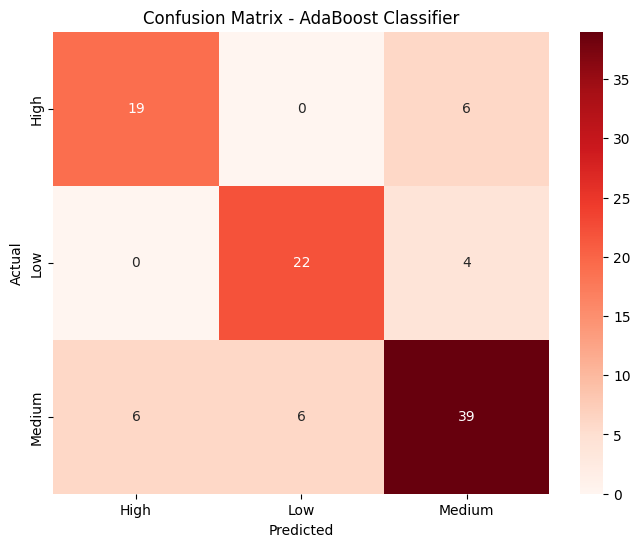

In [230]:
# Confusion Matrix
cm_abc = confusion_matrix(y_test, y_pred_abc)
cm_abc_df = pd.DataFrame(cm_abc, 
                        index=['High', 'Low', 'Medium'], 
                        columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_abc_df, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - AdaBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [231]:
# ROC and AUC Analysis for AdaBoost Classifier
print("ROC CURVE AND AUC ANALYSIS - ADABOOST")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_abc = ABC.predict_proba(X_test)
classes_abc = ABC.classes_
n_classes_abc = len(classes_abc)

print(f"Classes: {classes_abc}")
print(f"Prediction probabilities shape: {y_pred_proba_abc.shape}")

ROC CURVE AND AUC ANALYSIS - ADABOOST
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


In [232]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_abc = label_binarize(y_test, classes=classes_abc)

# Compute ROC curve and AUC for each class
fpr_abc = dict()
tpr_abc = dict()
roc_auc_abc = dict()

for i in range(n_classes_abc):
    fpr_abc[i], tpr_abc[i], _ = roc_curve(y_test_bin_abc[:, i], y_pred_proba_abc[:, i])
    roc_auc_abc[i] = auc(fpr_abc[i], tpr_abc[i])

# Compute micro-average ROC curve and AUC
fpr_abc["micro"], tpr_abc["micro"], _ = roc_curve(y_test_bin_abc.ravel(), y_pred_proba_abc.ravel())
roc_auc_abc["micro"] = auc(fpr_abc["micro"], tpr_abc["micro"])

In [233]:
# Print AUC scores for AdaBoost
print("\nAUC SCORES - ADABOOST:")
print("-" * 40)
for i, class_name in enumerate(classes_abc):
    print(f"{class_name:8} : {roc_auc_abc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_abc['micro']:.4f}")


AUC SCORES - ADABOOST:
----------------------------------------
High     : 0.9408
Low      : 0.9453
Medium   : 0.8085
Micro-avg : 0.9102


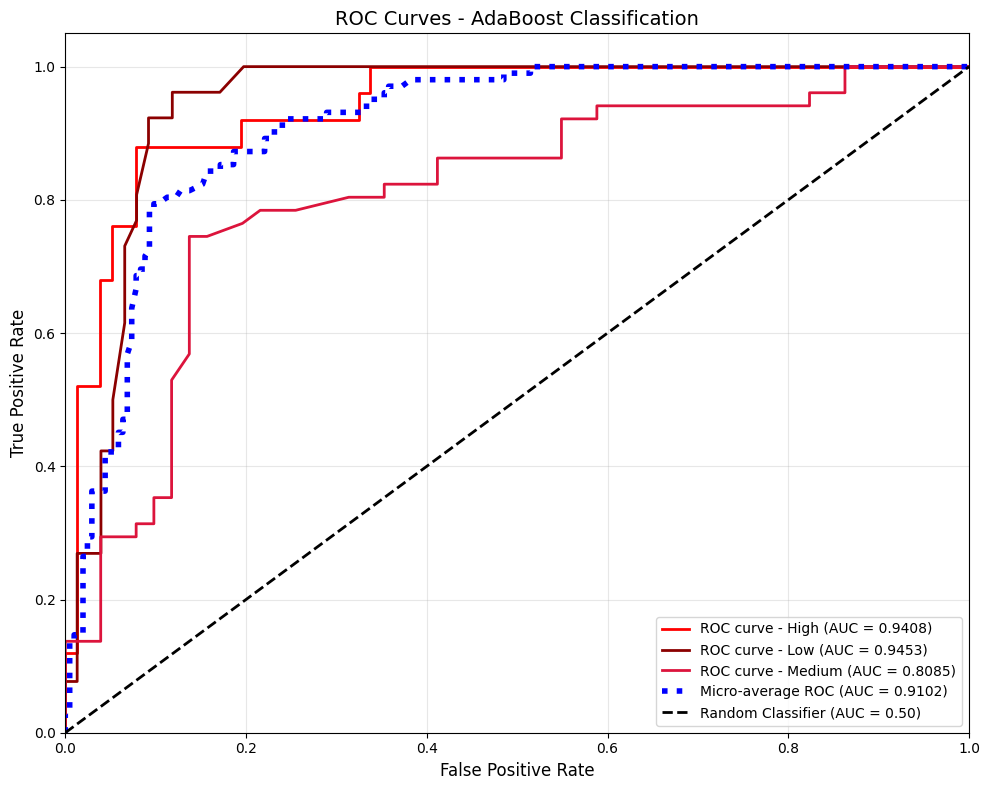

In [234]:
# Plot ROC curves for AdaBoost
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(['red', 'darkred', 'crimson'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_abc), colors, classes_abc):
    plt.plot(fpr_abc[i], tpr_abc[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_abc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_abc["micro"], tpr_abc["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_abc["micro"]:.4f})',
         color='blue', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - AdaBoost Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [235]:
# Calculate overall AUC scores using different methods for AdaBoost
auc_ovr_abc = roc_auc_score(y_test, y_pred_proba_abc, multi_class='ovr', average='weighted')
auc_ovo_abc = roc_auc_score(y_test, y_pred_proba_abc, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - ADABOOST:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_abc:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_abc:.4f}")
print(f"Micro-average          : {roc_auc_abc['micro']:.4f}")


OVERALL AUC SCORES - ADABOOST:
----------------------------------------
One-vs-Rest (Weighted) : 0.8758
One-vs-One (Weighted)  : 0.8958
Micro-average          : 0.9102



FEATURE IMPORTANCE - ADABOOST CLASSIFIER (TOP 10)
    feature  importance
12    LSTAT    0.252390
7       DIS    0.178755
5        RM    0.164867
8       RAD    0.093505
4       NOX    0.082248
0      CRIM    0.062747
10  PTRATIO    0.058135
2     INDUS    0.057988
9       TAX    0.023759
11        B    0.015098


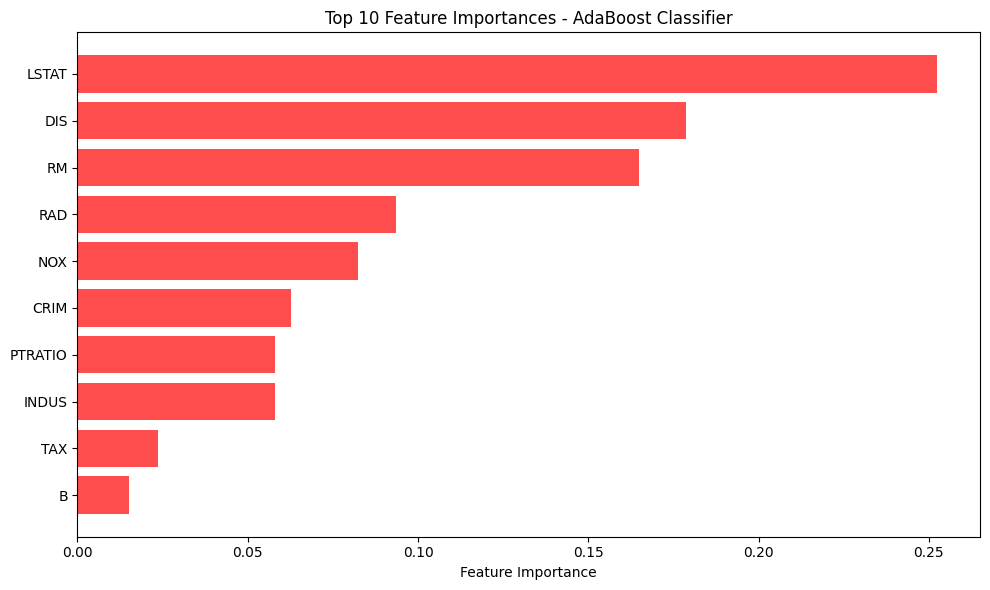

In [236]:
# Feature Importance for AdaBoost
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_abc = pd.DataFrame({
    'feature': feature_names,
    'importance': ABC.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - ADABOOST CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_abc.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_abc.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='red', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - AdaBoost Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### LightGBM

In [237]:
# Create LightGBM Classifier
LGBM = LGBMClassifier(
    random_state=42,
    verbose=1,  # Shows training progress
    objective='multiclass',
    num_class=3,
    metric='multi_logloss'
)
LGBM

LGBMClassifier(metric='multi_logloss', num_class=3, objective='multiclass',
               random_state=42, verbose=1)

In [238]:
%%time
LGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 13
[LightGBM] [Info] Start training from score -1.406295
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -0.683295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

LGBMClassifier(metric='multi_logloss', num_class=3, objective='multiclass',
               random_state=42, verbose=1)

In [239]:
y_pred_lgbm = LGBM.predict(X_test)
y_pred_lgbm

c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


array(['Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'Medium', 'High', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'High', 'Low', 'Low', 'Medium', 'High',
       'Medium', 'Low', 'High', 'Low', 'High', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium',
       'High', 'Low', 'Medium', 'Medium', 'Low', 'High', 'Low', 'Medium',
       'Me

In [240]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [241]:
accuracy_LGBM = accuracy_score(y_test, y_pred_lgbm)
precision_LGBM = precision_score(y_test, y_pred_lgbm, average='weighted')
recall_LGBM = recall_score(y_test, y_pred_lgbm, average='weighted')
f1_LGBM = f1_score(y_test, y_pred_lgbm, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="LightGBM Classifier",
    model=LGBM,
    scaler=scaler,
    accuracy=accuracy_LGBM,
    precision=precision_LGBM,
    recall=recall_LGBM,
    f1=f1_LGBM,
    parameters=LGBM.get_params()
)

LightGBM Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\lightgbm_classifier_standard_20250713_133315.pkl
    New scaler saved to: saved_models_classification\lightgbm_classifier_scaler_standard_20250713_133315.pkl


True

In [242]:
print("LIGHTGBM CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_LGBM:.4f}")
print(f"Precision: {precision_LGBM:.4f}")
print(f"Recall:    {recall_LGBM:.4f}")
print(f"F1-Score:  {f1_LGBM:.4f}")

LIGHTGBM CLASSIFICATION RESULTS
Accuracy:  0.8725
Precision: 0.8780
Recall:    0.8725
F1-Score:  0.8717


In [243]:
print("\nDETAILED CLASSIFICATION REPORT - LIGHTGBM")
print("="*60)
print(classification_report(y_test, y_pred_lgbm))


DETAILED CLASSIFICATION REPORT - LIGHTGBM
              precision    recall  f1-score   support

        High       0.95      0.76      0.84        25
         Low       0.88      0.88      0.88        26
      Medium       0.84      0.92      0.88        51

    accuracy                           0.87       102
   macro avg       0.89      0.86      0.87       102
weighted avg       0.88      0.87      0.87       102



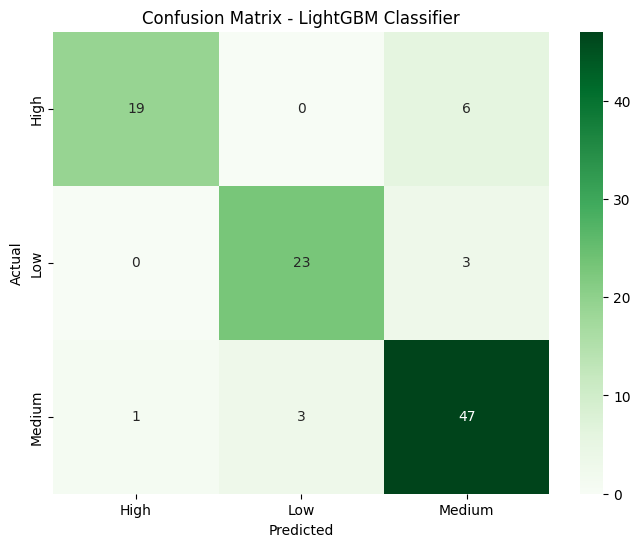

In [244]:
# Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_lgbm_df = pd.DataFrame(cm_lgbm, 
                         index=['High', 'Low', 'Medium'], 
                         columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm_df, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - LightGBM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [245]:
# ROC and AUC Analysis for LightGBM Classifier
print("ROC CURVE AND AUC ANALYSIS - LIGHTGBM")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_lgbm = LGBM.predict_proba(X_test)
classes_lgbm = LGBM.classes_
n_classes_lgbm = len(classes_lgbm)

print(f"Classes: {classes_lgbm}")
print(f"Prediction probabilities shape: {y_pred_proba_lgbm.shape}")

ROC CURVE AND AUC ANALYSIS - LIGHTGBM
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [246]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_lgbm = label_binarize(y_test, classes=classes_lgbm)

# Compute ROC curve and AUC for each class
fpr_lgbm = dict()
tpr_lgbm = dict()
roc_auc_lgbm = dict()

for i in range(n_classes_lgbm):
    fpr_lgbm[i], tpr_lgbm[i], _ = roc_curve(y_test_bin_lgbm[:, i], y_pred_proba_lgbm[:, i])
    roc_auc_lgbm[i] = auc(fpr_lgbm[i], tpr_lgbm[i])

# Compute micro-average ROC curve and AUC
fpr_lgbm["micro"], tpr_lgbm["micro"], _ = roc_curve(y_test_bin_lgbm.ravel(), y_pred_proba_lgbm.ravel())
roc_auc_lgbm["micro"] = auc(fpr_lgbm["micro"], tpr_lgbm["micro"])

In [247]:
# Print AUC scores for LightGBM
print("\nAUC SCORES - LIGHTGBM:")
print("-" * 40)
for i, class_name in enumerate(classes_lgbm):
    print(f"{class_name:8} : {roc_auc_lgbm[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_lgbm['micro']:.4f}")


AUC SCORES - LIGHTGBM:
----------------------------------------
High     : 0.9725
Low      : 0.9605
Medium   : 0.9273
Micro-avg : 0.9603


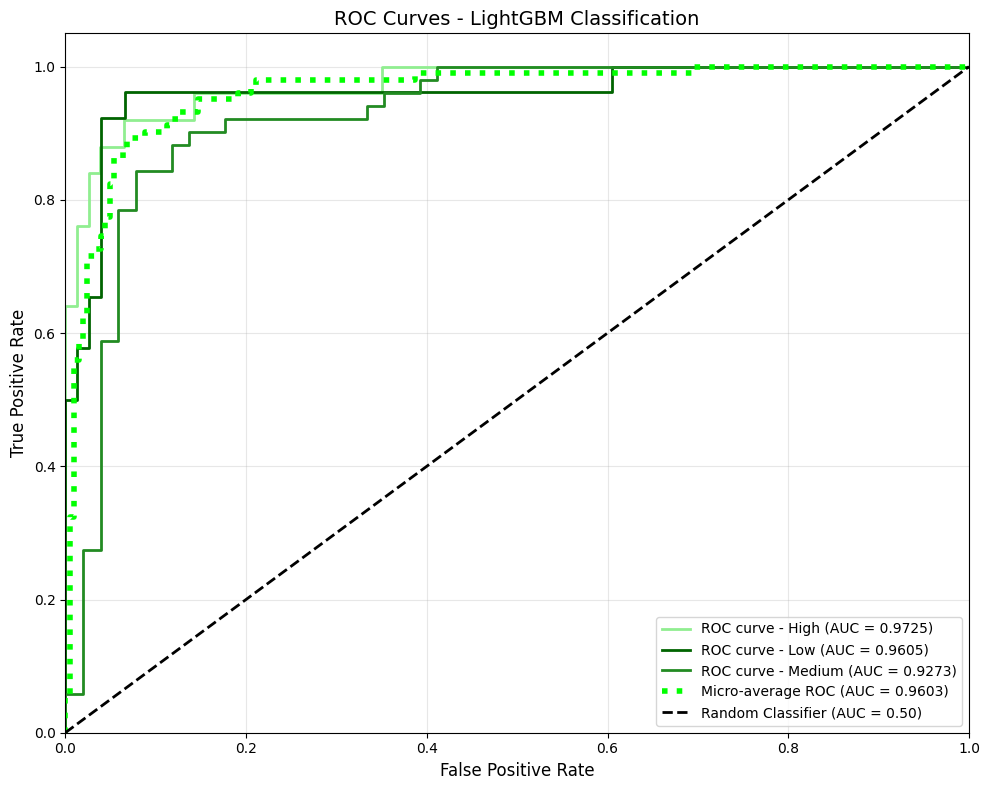

In [248]:
# Plot ROC curves for LightGBM
plt.figure(figsize=(10, 8))

# Colors for different classes (using green theme for LightGBM)
colors = cycle(['lightgreen', 'darkgreen', 'forestgreen'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_lgbm), colors, classes_lgbm):
    plt.plot(fpr_lgbm[i], tpr_lgbm[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_lgbm[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_lgbm["micro"], tpr_lgbm["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_lgbm["micro"]:.4f})',
         color='lime', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - LightGBM Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [249]:
# Calculate overall AUC scores using different methods for LightGBM
auc_ovr_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm, multi_class='ovr', average='weighted')
auc_ovo_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - LIGHTGBM:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_lgbm:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_lgbm:.4f}")
print(f"Micro-average          : {roc_auc_lgbm['micro']:.4f}")


OVERALL AUC SCORES - LIGHTGBM:
----------------------------------------
One-vs-Rest (Weighted) : 0.9469
One-vs-One (Weighted)  : 0.9532
Micro-average          : 0.9603



FEATURE IMPORTANCE - LIGHTGBM CLASSIFIER (TOP 10)
    feature  importance
12    LSTAT         893
5        RM         820
7       DIS         772
11        B         544
0      CRIM         543
6       AGE         520
4       NOX         385
2     INDUS         280
10  PTRATIO         272
9       TAX         244


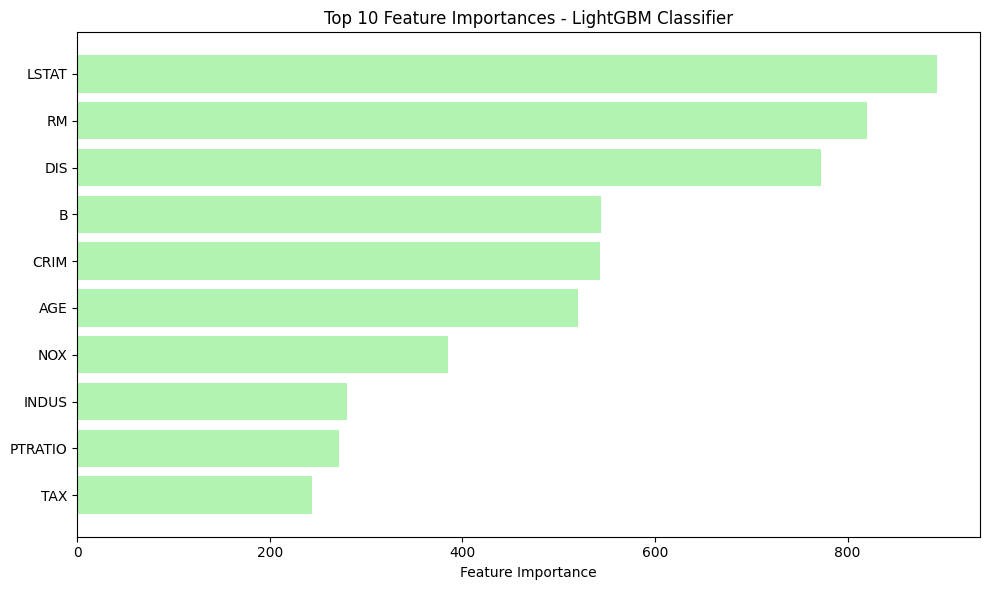

In [250]:
# Feature Importance for LightGBM
feature_names = boston.drop(columns=['MEDV', 'MEDV_Class']).columns

feature_importance_lgbm = pd.DataFrame({
    'feature': feature_names,
    'importance': LGBM.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE - LIGHTGBM CLASSIFIER (TOP 10)")
print("="*60)
print(feature_importance_lgbm.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_lgbm.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='lightgreen', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - LightGBM Classifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Stacking

In [251]:
# Define base classifiers for stacking
base_classifiers = [
    ('logistic', LogisticRegression(random_state=42, max_iter=1000)),
    ('random_forest', RandomForestClassifier(random_state=42, n_estimators=100)),
    ('svm', SVC(random_state=42, probability=True)),
    ('gradient_boost', GradientBoostingClassifier(random_state=42, n_estimators=100)),
    ('ada_boost', AdaBoostClassifier(random_state=42, n_estimators=100, algorithm='SAMME')),
    ('lightgbm', LGBMClassifier(random_state=42, verbose=-1, objective='multiclass', num_class=3))
]

# Define meta-classifier (final estimator)
meta_classifier = LogisticRegression(random_state=42, max_iter=1000)

In [252]:
# Create Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5,  # Cross-validation folds for training base classifiers
    stack_method='predict_proba',  # Use probabilities for stacking
    n_jobs=-1,
    verbose=1
)

stacking_clf

StackingClassifier(cv=5,
                   estimators=[('logistic',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42)),
                               ('random_forest',
                                RandomForestClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('gradient_boost',
                                GradientBoostingClassifier(random_state=42)),
                               ('ada_boost',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   n_estimators=100,
                                                   random_state=42)),
                               ('lightgbm',
                                LGBMClassifier(num_class=3,
                                               objective='multiclass',
                                               random_state=42, verbose=-1))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1, stack_method='predict_proba', verbose=1)

In [253]:
%%time
print("Training Stacking Classifier with base models:")
for name, model in base_classifiers:
    print(f"  - {name}: {type(model).__name__}")
print(f"Meta-classifier: {type(meta_classifier).__name__}")
print()

stacking_clf.fit(X_train, y_train)

Training Stacking Classifier with base models:
  - logistic: LogisticRegression
  - random_forest: RandomForestClassifier
  - svm: SVC
  - gradient_boost: GradientBoostingClassifier
  - ada_boost: AdaBoostClassifier
  - lightgbm: LGBMClassifier
Meta-classifier: LogisticRegression

CPU times: total: 203 ms
Wall time: 10.5 s


StackingClassifier(cv=5,
                   estimators=[('logistic',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42)),
                               ('random_forest',
                                RandomForestClassifier(random_state=42)),
                               ('svm', SVC(probability=True, random_state=42)),
                               ('gradient_boost',
                                GradientBoostingClassifier(random_state=42)),
                               ('ada_boost',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   n_estimators=100,
                                                   random_state=42)),
                               ('lightgbm',
                                LGBMClassifier(num_class=3,
                                               objective='multiclass',
                                               random_state=42, verbose=-1))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1, stack_method='predict_proba', verbose=1)

In [254]:
y_pred_stacking = stacking_clf.predict(X_test)
y_pred_stacking

c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


array(['Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium', 'Medium',
       'Medium', 'High', 'Medium', 'High', 'Low', 'Medium', 'Medium',
       'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Medium', 'Medium',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'High',
       'Medium', 'Low', 'High', 'Low', 'Medium', 'High', 'Low', 'High',
       'Medium', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Medium', 'Medium', 'High', 'Medium', 'High',
       'Medium', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Low',
       'High', 'High', 'Medium', 'High', 'Medium', 'Medium', 'Medium',
       'High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Low',
       'Medium', 'Medium', 'Medium', 'Medium', 'Medium', 'Low', 'Medium',
       'High', 'Low', 'Low', 'Medium', 'Low', 'High', 'Low', 'Medium',
       'Medi

In [255]:
y_test

399       Low
503    Medium
27        Low
119    Medium
492    Medium
        ...  
156       Low
4        High
20        Low
70     Medium
314    Medium
Name: MEDV_Class, Length: 102, dtype: object

In [256]:
accuracy_Stacking = accuracy_score(y_test, y_pred_stacking)
precision_Stacking = precision_score(y_test, y_pred_stacking, average='weighted')
recall_Stacking = recall_score(y_test, y_pred_stacking, average='weighted')
f1_Stacking = f1_score(y_test, y_pred_stacking, average='weighted')

# Save model if better
save_model_if_better_classification(
    model_name="Stacking Classifier",
    model=stacking_clf,
    scaler=scaler,
    accuracy=accuracy_Stacking,
    precision=precision_Stacking,
    recall=recall_Stacking,
    f1=f1_Stacking,
    parameters=stacking_clf.get_params()
)

Stacking Classifier (standard): First time training - saving model
    New model saved to: saved_models_classification\stacking_classifier_standard_20250713_133326.pkl
    New scaler saved to: saved_models_classification\stacking_classifier_scaler_standard_20250713_133326.pkl


True

In [257]:
print("STACKING CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_Stacking:.4f}")
print(f"Precision: {precision_Stacking:.4f}")
print(f"Recall:    {recall_Stacking:.4f}")
print(f"F1-Score:  {f1_Stacking:.4f}")

STACKING CLASSIFICATION RESULTS
Accuracy:  0.8725
Precision: 0.8787
Recall:    0.8725
F1-Score:  0.8691


In [258]:
print("\nDETAILED CLASSIFICATION REPORT - STACKING")
print("="*60)
print(classification_report(y_test, y_pred_stacking))


DETAILED CLASSIFICATION REPORT - STACKING
              precision    recall  f1-score   support

        High       0.94      0.68      0.79        25
         Low       0.89      0.96      0.93        26
      Medium       0.84      0.92      0.88        51

    accuracy                           0.87       102
   macro avg       0.89      0.85      0.87       102
weighted avg       0.88      0.87      0.87       102



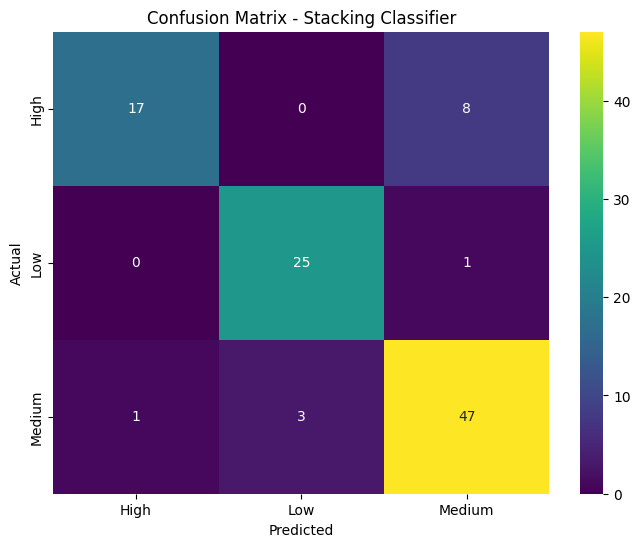

In [259]:
# Confusion Matrix
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
cm_stacking_df = pd.DataFrame(cm_stacking, 
                             index=['High', 'Low', 'Medium'], 
                             columns=['High', 'Low', 'Medium'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking_df, annot=True, fmt='d', cmap='viridis', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [260]:
# ROC and AUC Analysis for Stacking Classifier
print("ROC CURVE AND AUC ANALYSIS - STACKING")
print("="*60)

# Get prediction probabilities for all classes
y_pred_proba_stacking = stacking_clf.predict_proba(X_test)
classes_stacking = stacking_clf.classes_
n_classes_stacking = len(classes_stacking)

print(f"Classes: {classes_stacking}")
print(f"Prediction probabilities shape: {y_pred_proba_stacking.shape}")

ROC CURVE AND AUC ANALYSIS - STACKING
Classes: ['High' 'Low' 'Medium']
Prediction probabilities shape: (102, 3)


c:\Users\joyde\Documents\GitHub\BostonML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [261]:
# Convert multi-class to binary format for ROC analysis
y_test_bin_stacking = label_binarize(y_test, classes=classes_stacking)

# Compute ROC curve and AUC for each class
fpr_stacking = dict()
tpr_stacking = dict()
roc_auc_stacking = dict()

for i in range(n_classes_stacking):
    fpr_stacking[i], tpr_stacking[i], _ = roc_curve(y_test_bin_stacking[:, i], y_pred_proba_stacking[:, i])
    roc_auc_stacking[i] = auc(fpr_stacking[i], tpr_stacking[i])

# Compute micro-average ROC curve and AUC
fpr_stacking["micro"], tpr_stacking["micro"], _ = roc_curve(y_test_bin_stacking.ravel(), y_pred_proba_stacking.ravel())
roc_auc_stacking["micro"] = auc(fpr_stacking["micro"], tpr_stacking["micro"])

In [262]:
# Print AUC scores for Stacking
print("\nAUC SCORES - STACKING:")
print("-" * 40)
for i, class_name in enumerate(classes_stacking):
    print(f"{class_name:8} : {roc_auc_stacking[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc_stacking['micro']:.4f}")


AUC SCORES - STACKING:
----------------------------------------
High     : 0.9527
Low      : 0.9701
Medium   : 0.9116
Micro-avg : 0.9524


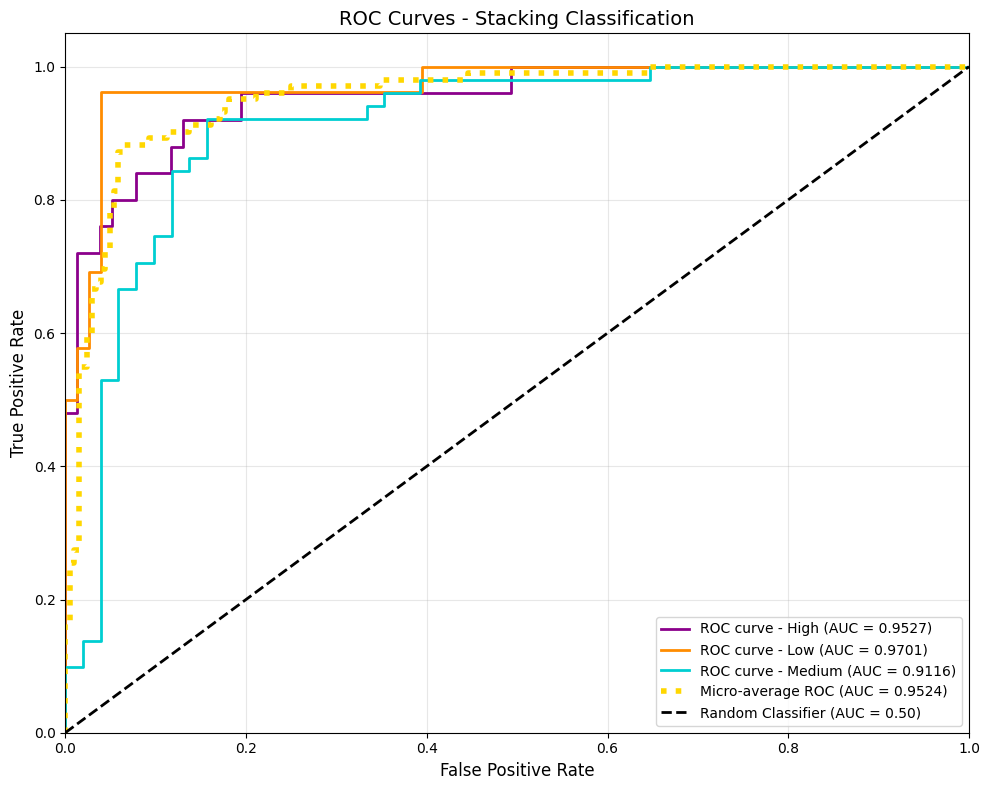

In [263]:
# Plot ROC curves for Stacking
plt.figure(figsize=(10, 8))

# Colors for different classes (using viridis theme for Stacking)
colors = cycle(['darkmagenta', 'darkorange', 'darkturquoise'])

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes_stacking), colors, classes_stacking):
    plt.plot(fpr_stacking[i], tpr_stacking[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc_stacking[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr_stacking["micro"], tpr_stacking["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc_stacking["micro"]:.4f})',
         color='gold', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Stacking Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [264]:
# Calculate overall AUC scores using different methods for Stacking
auc_ovr_stacking = roc_auc_score(y_test, y_pred_proba_stacking, multi_class='ovr', average='weighted')
auc_ovo_stacking = roc_auc_score(y_test, y_pred_proba_stacking, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES - STACKING:")
print("-" * 40)
print(f"One-vs-Rest (Weighted) : {auc_ovr_stacking:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo_stacking:.4f}")
print(f"Micro-average          : {roc_auc_stacking['micro']:.4f}")


OVERALL AUC SCORES - STACKING:
----------------------------------------
One-vs-Rest (Weighted) : 0.9366
One-vs-One (Weighted)  : 0.9447
Micro-average          : 0.9524


### Comparison of All Classifier Model

In [265]:
show_model_registry_classification()


CLASSIFICATION MODEL REGISTRY - BEST PERFORMING MODELS (Sorted by F1)
                      model_name scaler_type  accuracy  precision   recall       f1       timestamp
    Gradient Boosting Classifier    standard  0.882353   0.886695 0.882353 0.881223 20250713_133306
    Gradient Boosting Classifier      minmax  0.882353   0.886695 0.882353 0.881223 20250713_024840
             LightGBM Classifier    standard  0.872549   0.877976 0.872549 0.871714 20250713_133315
             Stacking Classifier      minmax  0.872549   0.878715 0.872549 0.869071 20250713_025126
             Stacking Classifier    standard  0.872549   0.878715 0.872549 0.869071 20250713_133326
        Random Forest Classifier    standard  0.862745   0.865071 0.862745 0.859377 20250713_133249
        Random Forest Classifier      minmax  0.862745   0.865071 0.862745 0.859377 20250711_151813
             LightGBM Classifier      minmax  0.852941   0.855561 0.852941 0.852279 20250713_025003
Bagging Random Forest Classif